# Libraries

In [8]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd


from scipy import signal
from scipy.io import wavfile

# from pybv import write_brainvision
from pyprep.prep_pipeline import PrepPipeline
from mne_icalabel import label_components

# set working directory
work_dir = '/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/'

# Trigger lag fix

## parameters

In [99]:
# directory
input_dir = work_dir + 'data_raw/'
output_dir = work_dir + 'data_preprocessed/1_trigger_lag_fixed/'
# create a folder if the folder doesn't exist
os.makedirs(output_dir, exist_ok=True)

# create a dictionary for blocks and markers
block_dict = {
    'ChEn':1000, # standard: chinese; deviant: english
    'EnCh':2000, # standard: english; deviant: chinese
    'InEn':3000, # standard: indian; deviant: english
    'EnIn':4000, # standard: english, deviant: indian
}


# exclude participants with missing data
exclude_subs = [
    'Yas_115', # what's the reason for this one?
    'Yas_140', # no data
    'Yas_141', # wrong experiment was run
    'Yas_261', # no StimTrak recording
]

# trigger searching window (actual trigger time based on audio - trigger time in the data)
t_left = -0.01
t_right = 0.05

Extracting parameters from /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_raw/Yas_259.vhdr...
Setting channel info structure...
Reading 0 ... 1798149  =      0.000 ...  3596.298 secs...
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_259_corr.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/593251600.py:254: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_259_corr.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_corr.fif')


Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_259_corr.fif
[done]


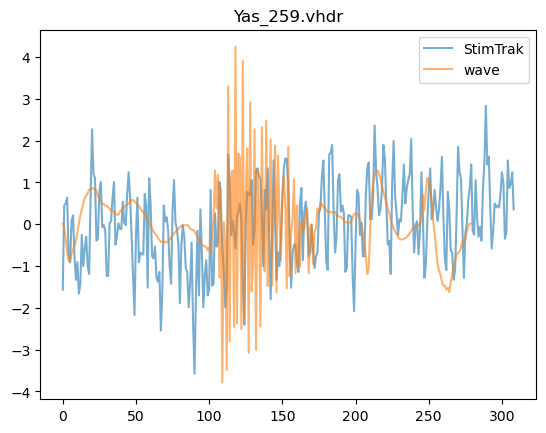

In [101]:
#######################################################
#### create a dictionary for trigger codes and descriptions ####
df = pd.read_csv("mapping.txt", delimiter='\t')
mapping = dict(zip(df['code'], df['description']))
#######################################################

#### create a trigger dictionary for each stim's standard version and deviant version ####

# intialize a dictionary for triggers
trigger_dict = {}

# read in trigger_codes file
with open('trigger_codes.txt','r') as tf:
    for line in tf:
        # read in the current line
        line = line.replace('\n','')
        # separate fileNames and triggerMarker
        label, marker = line.split('\t')
        # convert trigger markers to integer
        marker = int(marker)
        # create label for stims used as standards
        trigger_dict[marker] = label + '-s'
        # add 100 for deviant marker
        marker_deviant = marker + 100
        # create label for stims used as deviants
        trigger_dict[marker_deviant] = label + '-d'



#### trigger correction for each file ####

# initialize a dictionary to save bad stims
all_bad_stim_dict = {}

# read in eeg data files
all_files = os.listdir(input_dir)

#### for each file, create an all_block dictionary to store each block and the indices of trials of that block  ####
for file in all_files:
    if file.endswith(".vhdr") and (file.split('.')[0] not in exclude_subs) and (file.split('.')[0]+ '_corr.fif' not in os.listdir(output_dir)):
        
        # read in vhdr files
        raw = mne.io.read_raw_brainvision(input_dir + file, preload = True)

        # extract sampling rate
        eeg_sfreq = raw.info['sfreq']
        
        # If the aux channel is not named 'StimTrak', change the channel name to 'StimTrak'
        if raw.info['ch_names'][31] != 'StimTrak':
            # change the channel name
            raw.rename_channels({raw.info['ch_names'][31]: 'StimTrak'})
            # specify the audio channel
            raw.set_channel_types({'StimTrak':'misc'})

        ##########################################################################################
        #### get trigger code, audio data, create a trigger dictionary for each stim's standard version and deviant version ####

        # initialize dictionaries
        audio = {}
        lengths = {}
        
        # del trigger_dict[99999]
        for marker,label in trigger_dict.items():
            # extract file name
            file_name = label[:7]
            # if not already in audio dictionary, get the info of the audio file
            if file_name not in audio:
                # get sample rate and data of the audio file
                sampleRate, data = wavfile.read(work_dir + 'experiment_program/stimuli/{}.wav'.format(file_name))
                # calculate sound file length
                lengths[file_name] = len(data)/sampleRate
                # reduce the sampling rate of the audio file by the factor of int(sampleRate/eeg_freq)
                data_downsampled = signal.decimate(data,int(sampleRate/eeg_sfreq), ftype='fir')
                # add info the audio dictionary
                audio[file_name] = data_downsampled

        #### making events ####
        # for each stimulus, mark the block info
        events_from_annot, event_dict = mne.events_from_annotations(raw, verbose='WARNING')
        # remove useless markers (New Segment: 99999, pause: 222, and continue: 223)
        events_from_annot = events_from_annot[events_from_annot[:, 2] < 200]
                
        # initialize the train for each standards+deviant sequence
        train = np.array([]).astype(int)
        
        all_block = {}
        isStandard = True # whether the standard in a train has been noted
            
        # loop over each trigger
        for i in range(events_from_annot.shape[0]):
                
            # add the current token to the train
            train = np.append(train,i)

            # trigger code
            trigger_marker = events_from_annot[i,2]
            
            # if the trigger code is smaller than 100 and the standard note is true
            if (trigger_marker<100) & isStandard:
                # save the standard stim category
                block = trigger_dict[trigger_marker][:2]
                # toggle standard note
                standard = False

            # if the trigger value is over 100
            elif trigger_marker>100:
                # append the deviant stim category 
                block = block + trigger_dict[trigger_marker][:2]

                # if the block is not present in all block
                if block not in all_block:
                    # add the new block and the token idx
                    all_block[block] = train[2:] # [2:] to exclude the first 2 standards
                else:
                    # add the token idx to the existing block
                    all_block[block] = np.concatenate([ all_block[block], train[2:] ], axis=None)

                # reset train
                train = np.array([]).astype(int)

                # toggle standard note
                isStandard = True
        
        # loop over each block and its trigger index
        for k,v in all_block.items(): 
            # recode the trigger value to reflect block and stim category
            events_from_annot[tuple(v),2] += block_dict[k]

        # exclude the first 2 standards
        events_from_annot = events_from_annot[events_from_annot[:,2]>1000]
        ##########################################################################################
        
        ########################################################
        #### calculate cross correction to detect the delay ####
        
        # initialize delay list
        delays = np.array([])
        # initialize bad stim list
        bad_stim = []
        corr_results = []
        
        # loop over each event
        for i in range(events_from_annot.shape[0]):

            # get current event info [time, duration, annotation]
            event = events_from_annot[i]
            # get the onset latency (s) of the event
            time = event[0]/eeg_sfreq
            # get the file name of the event
            name = trigger_dict[event[2]%100].split('-')[0]
            # get the data from the sound channel
            audio_eeg = raw.get_data(
                picks = ['StimTrak'],
                tmin = time + t_left,
                tmax = time + lengths[name] + t_right,
            )[0]
            # actual stimulus
            audio_stim = audio[name]
            
            # Z-score normalization (subtract mean, divide by std)
            audio_eeg = (audio_eeg - np.mean(audio_eeg)) / np.std(audio_eeg)
            audio_stim = (audio_stim - np.mean(audio_stim)) / np.std(audio_stim)

            # cross-correlation
            corr = signal.correlate(audio_eeg, audio_stim, mode='full')
            # Normalize cross-correlation
            corr = corr / (np.linalg.norm(audio_eeg) * np.linalg.norm(audio_stim))
            # Find peak correlation value
            max_corr = np.max(corr)    
            
            # if the maximum correction (sum of products) is less than a threshold (empirical, but 0.5 is good for most cases)
            if max_corr < 0.5:
                # mark the stim bad
                bad_stim.append(i)
            
            # append the maximum correlation
            corr_results.append(max_corr)
            
            # the lags for cross-correlation
            lags = signal.correlation_lags(
                audio_eeg.size,
                audio_stim.size,
                mode="full")
            # get the lag of the maximum cross-correlation
            lag = lags[np.argmax(corr)] + t_left*eeg_sfreq
            
            # save the lag for non-starting events
            delays = np.append(delays, lag)
        ########################################################

        ##################################################################################################
        #### plot the wave from the stim track and the eeg channel of the token with the minimum corr ####
        
        min_corr = np.argmin(corr_results)
        # get current event info [time, duration, annotation]
        event = events_from_annot[min_corr]
        # get the onset latency (s) of the event
        time = event[0]/eeg_sfreq
        # get the file name of the event
        name = trigger_dict[event[2]%100].split('-')[0]
        # get the data from the sound channel
        audio_eeg = raw.get_data(
            picks = ['StimTrak'],
            tmin = time + t_left,
            tmax = time + lengths[name] + t_right,
        )[0]
        # actual stimulus
        audio_stim = audio[name]
        # Z-score normalization (subtract mean, divide by std)
        audio_eeg = (audio_eeg - np.mean(audio_eeg)) / np.std(audio_eeg)
        audio_stim = (audio_stim - np.mean(audio_stim)) / np.std(audio_stim)
        # plot
        fig, ax = plt.subplots()
        ax.plot(audio_eeg, label = 'StimTrak', alpha = 0.6)
        ax.plot(audio_stim, label = 'wave', alpha = 0.6)
        ax.set_title(file)
        ax.legend()
        fig.savefig(output_dir + file.split('.')[0] + "_minCor.png", dpi=300, bbox_inches='tight')
        ##################################################################################################

                
        ####################################################
        #### correct for trigger lag and save log files ####

        # add number of bad stim info
        all_bad_stim_dict[file] = len(bad_stim)

        # remove items associated with bad stims from the event list
        events_from_annot = np.delete(events_from_annot, bad_stim, 0)
        
        # remove items associated with bad stims from the delay list
        delays = np.delete(delays, bad_stim, 0)

        # add delay back to the onset latency of each event
        events_from_annot[:,0] = events_from_annot[:,0] + delays

        # # convert individual event marker to conditions
        # events_from_annot[:,2] = events_from_annot[:,2] - events_from_annot[:,2]%100

        # create annotations
        annot_from_events = mne.annotations_from_events(
            events = events_from_annot,
            event_desc = mapping,
            sfreq = raw.info['sfreq']
        )

        # set annotations
        raw.set_annotations(annot_from_events)
        
        # drop the audio channel in data
        raw.drop_channels(['StimTrak'])
        
        # save as a file-into-file data
        raw.save(output_dir + file.split('.')[0]+ '_corr.fif')
        
        # save lag data
        np.savetxt(output_dir + file.replace('.vhdr', '_delays.txt'), delays, fmt='%i')
        ####################################################
        

# save the number of bad stims of all participant
with open(output_dir + 'bad_stim.txt', 'a') as f:
    for key, value in all_bad_stim_dict.items():
        if value > 0:
            f.write(key + '\t' + str(value) + '\n')

# Bad channel correction
- filtering
- resampling
- remove line noise
- bad channel detection & repairing
- add back reference channel TP9

## parameters

In [102]:
# set directory
input_dir = work_dir + 'data_preprocessed/1_trigger_lag_fixed/'
output_dir = work_dir + 'data_preprocessed/2_bad_channel_corrected/'
# create a folder if the folder doesn't exist
os.makedirs(output_dir, exist_ok=True)

# filter cutoff frequencies (low/high)
f_low = 1
f_high = 100

# resampling frequency
f_res = 250

# line frequency
line_freq = 60

# preprocessing parameters
prep_params = {
    "ref_chs": 'eeg',
    "reref_chs": 'eeg', # average re-reference
    "line_freqs": np.arange(line_freq, f_res/2, line_freq),
}

# create a montage file for the pipeline
montage = mne.channels.make_standard_montage("standard_1020")

# interpolation method
# method=dict(eeg="spline")

In [103]:
#####################################################
#### Preprocessing (filtering, resampling, bad channel detection/interpoloation, re-reference) ####
#####################################################

# get all file namesin the folder
all_input = os.listdir(input_dir)
all_output = os.listdir(output_dir)


for file in all_input:
    if file.endswith("corr.fif") & (file.split('.')[0]+ '_prep.fif' not in all_output):
        
        # read in file
        raw = mne.io.read_raw_fif(input_dir + file, preload=True)
        
        # set channel type
        raw.set_channel_types({'Fp1':'eog', 'Fp2':'eog'})

        # filter
        raw.filter(l_freq = f_low, h_freq = f_high)
        
        #### cut off the beginning and ending part ####
        
        # get the onset of the first and the last event ####
        events_from_annot, event_dict = mne.events_from_annotations(raw, verbose='WARNING')

        # define the beginning time (in seconds)
        crop_start = events_from_annot[0][0]/raw.info['sfreq'] - 10

        # define the ending time (in seconds)
        crop_end = events_from_annot[-1][0]/raw.info['sfreq'] + 10

        # crop the data
        raw.crop(
            tmin=max(crop_start, raw.times[0]), 
            tmax=min(crop_end, raw.times[-1])
        )
        
        # resample
        raw.resample(sfreq = f_res)

        # read in channel location info
        raw.set_montage(montage)
        
        ####  Use PrePipeline to preprocess ####
        '''
        1. detect and interpolate bad channels
        2. remove line noise
        3. re-reference
        '''
        
        # apply pyprep
        prep = PrepPipeline(raw, prep_params, montage, random_state=42)
        prep.fit()

        
        # export a txt file for the interpolated channel info
        with open(output_dir + 'bad_channel.txt', 'a+') as f:
            _ =f.write(
                file + ':\n' +
                "- Bad channels original: {}".format(prep.noisy_channels_original["bad_all"]) + '\n' +
                "- Bad channels after robust average reference: {}".format(prep.interpolated_channels) + '\n' +
                "- Bad channels after interpolation: {}".format(prep.still_noisy_channels) + '\n'
            )

        # save the pypred preprocessed data into the raw data structure
        raw = prep.raw

        # add back the reference channel
        raw = mne.add_reference_channels(raw,'TP9')

        # add the channel loc info (for the newly added reference channel)
        raw.set_montage(montage)
        
        # save
        raw.save(output_dir + file.split('.')[0]+ '_prep.fif')

Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_267_corr.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:14: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_267_corr.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Isotrak not found
    Range : 0 ... 1848299 =      0.000 ...  3696.598 secs
Ready.
Reading 0 ... 1848299  =      0.000 ...  3696.598 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:43: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Removed notch frequencies (Hz):
     60.00 : 20068 windows
    120.00 : 20068 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/693 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:12:42,026 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['O1'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['O1']}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/693 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:13:13,232 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['TP10', 'T7', 'O1'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['T7', 'TP10', 'O1']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 26 sensor positions
Interpolating 3 sensors


2025-06-25 17:13:13,640 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/693 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:13:42,154 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['T7', 'TP10', 'O1'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['TP10', 'T7', 'O1']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 26 sensor positions
Interpolating 3 sensors


2025-06-25 17:13:42,450 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/693 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:14:11,313 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['TP10', 'T7', 'O1'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['T7', 'TP10', 'O1']}
2025-06-25 17:14:11,340 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 26 sensor positions
Interpolating 3 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/693 [00:00<?,       ?it/s]


RANSAC done!
Found 3 uniquely bad channels:

0 by NaN: []

0 by flat: []

0 by deviation: []

0 by HF noise: []

3 by correlation: ['T7', 'O1', 'TP10']

0 by SNR: []

0 by dropout: []

0 by RANSAC: []

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 26 sensor positions
Interpolating 3 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/693 [00:00<?,       ?it/s]


RANSAC done!
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_267_corr_prep.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:70: RuntimeWarning: Location for this channel is unknown or ambiguous; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.
  raw = mne.add_reference_channels(raw,'TP9')
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:73: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:76: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_267_corr

Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_267_corr_prep.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_259_corr.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:14: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_259_corr.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Isotrak not found
    Range : 0 ... 1798149 =      0.000 ...  3596.298 secs
Ready.
Reading 0 ... 1798149  =      0.000 ...  3596.298 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:43: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Removed notch frequencies (Hz):
     60.00 : 17342 windows
    120.00 : 17342 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/599 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:15:57,000 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': []}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/599 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:16:25,290 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['FT10'], 'bad_all': ['FT10']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 1 sensors


2025-06-25 17:16:25,534 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/599 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:16:53,510 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['FT10'], 'bad_all': ['FT10']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 1 sensors


2025-06-25 17:16:53,761 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/599 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:17:22,599 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['FT10'], 'bad_all': ['FT10']}
2025-06-25 17:17:22,601 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 1 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/599 [00:00<?,       ?it/s]


RANSAC done!
Found 1 uniquely bad channels:

0 by NaN: []

0 by flat: []

0 by deviation: []

0 by HF noise: []

0 by correlation: []

0 by SNR: []

0 by dropout: []

1 by RANSAC: ['FT10']

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 1 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/599 [00:00<?,       ?it/s]


RANSAC done!
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_259_corr_prep.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:70: RuntimeWarning: Location for this channel is unknown or ambiguous; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.
  raw = mne.add_reference_channels(raw,'TP9')
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:73: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:76: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_259_corr

Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_259_corr_prep.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_258_corr.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:14: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_258_corr.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Isotrak not found
    Range : 0 ... 1875024 =      0.000 ...  3750.048 secs
Ready.
Reading 0 ... 1875024  =      0.000 ...  3750.048 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:43: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Removed notch frequencies (Hz):
     60.00 : 20735 windows
    120.00 : 20735 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/716 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:19:14,284 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['T7'], 'bad_by_correlation': ['T7'], 'bad_by_SNR': ['T7'], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['T7']}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/716 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:19:47,939 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['T7'], 'bad_by_correlation': ['T7', 'T8', 'FT9'], 'bad_by_SNR': ['T7'], 'bad_by_dropout': [], 'bad_by_ransac': ['FT10'], 'bad_all': ['FT9', 'FT10', 'T8', 'T7']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 25 sensor positions
Interpolating 4 sensors


2025-06-25 17:19:48,431 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/716 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:20:19,209 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['T7'], 'bad_by_hf_noise': ['T7'], 'bad_by_correlation': ['FT9', 'FT10', 'T8', 'T7'], 'bad_by_SNR': ['T7'], 'bad_by_dropout': [], 'bad_by_ransac': ['FT10', 'F7'], 'bad_all': ['T8', 'FT9', 'F7', 'FT10', 'T7']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 24 sensor positions
Interpolating 5 sensors


2025-06-25 17:20:19,644 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/716 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:20:52,343 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['T7'], 'bad_by_hf_noise': ['T7'], 'bad_by_correlation': ['T8', 'FT9', 'F7', 'FT10', 'T7'], 'bad_by_SNR': ['T7'], 'bad_by_dropout': [], 'bad_by_ransac': ['FT10', 'F7'], 'bad_all': ['T8', 'FT9', 'F7', 'FT10', 'T7']}
2025-06-25 17:20:52,344 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 24 sensor positions
Interpolating 5 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/716 [00:00<?,       ?it/s]


RANSAC done!
Found 5 uniquely bad channels:

0 by NaN: []

0 by flat: []

1 by deviation: ['T7']

1 by HF noise: ['T7']

3 by correlation: ['FT9', 'T7', 'T8']

1 by SNR: ['T7']

0 by dropout: []

2 by RANSAC: ['F7', 'FT10']

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 24 sensor positions
Interpolating 5 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/716 [00:00<?,       ?it/s]


RANSAC done!
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_258_corr_prep.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:70: RuntimeWarning: Location for this channel is unknown or ambiguous; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.
  raw = mne.add_reference_channels(raw,'TP9')
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:73: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:76: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_258_corr

Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_258_corr_prep.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_260_corr.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:14: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_260_corr.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Isotrak not found
    Range : 0 ... 1804224 =      0.000 ...  3608.448 secs
Ready.
Reading 0 ... 1804224  =      0.000 ...  3608.448 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:43: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Removed notch frequencies (Hz):
     60.00 : 20097 windows
    120.00 : 20097 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/694 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:22:54,697 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['O2'], 'bad_by_hf_noise': [], 'bad_by_correlation': ['P7'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['O2', 'P7']}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/694 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:23:26,284 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['O2'], 'bad_by_hf_noise': ['O2'], 'bad_by_correlation': ['C3', 'T8', 'T7'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['O2', 'C3', 'T8', 'T7']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 25 sensor positions
Interpolating 4 sensors


2025-06-25 17:23:26,592 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/694 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:23:56,643 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['O2'], 'bad_by_hf_noise': ['O2'], 'bad_by_correlation': ['P7', 'CP5', 'T8', 'C3', 'T7'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['P7', 'CP5', 'T8', 'C3', 'O2', 'T7']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 23 sensor positions
Interpolating 6 sensors


2025-06-25 17:23:57,046 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/694 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:24:26,269 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['O2'], 'bad_by_hf_noise': ['O2'], 'bad_by_correlation': ['P7', 'T8', 'CP5', 'C3', 'T7'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['P7', 'CP5', 'T8', 'C3', 'O2', 'T7']}
2025-06-25 17:24:26,269 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 23 sensor positions
Interpolating 6 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/694 [00:00<?,       ?it/s]


RANSAC done!
Found 6 uniquely bad channels:

0 by NaN: []

0 by flat: []

1 by deviation: ['O2']

1 by HF noise: ['O2']

5 by correlation: ['C3', 'T7', 'CP5', 'P7', 'T8']

0 by SNR: []

0 by dropout: []

0 by RANSAC: []

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 23 sensor positions
Interpolating 6 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/694 [00:00<?,       ?it/s]


RANSAC done!
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_260_corr_prep.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:70: RuntimeWarning: Location for this channel is unknown or ambiguous; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.
  raw = mne.add_reference_channels(raw,'TP9')
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:73: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:76: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_260_corr

Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_260_corr_prep.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_264_corr.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:14: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_264_corr.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Isotrak not found
    Range : 0 ... 1692674 =      0.000 ...  3385.348 secs
Ready.
Reading 0 ... 1692674  =      0.000 ...  3385.348 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:43: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Removed notch frequencies (Hz):
     60.00 : 19575 windows
    120.00 : 19575 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/676 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:26:21,692 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['T7'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['FT9'], 'bad_all': ['FT9', 'T7']}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/676 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:26:55,715 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['T8'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['FT10', 'CP5'], 'bad_all': ['CP5', 'FT10', 'T8']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 26 sensor positions
Interpolating 3 sensors


2025-06-25 17:26:56,064 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/676 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:27:27,418 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['T8', 'FC6'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['F8', 'FT10', 'CP5', 'T7'], 'bad_all': ['T8', 'CP5', 'F8', 'FT10', 'FC6', 'T7']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 23 sensor positions
Interpolating 6 sensors


2025-06-25 17:27:27,750 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/676 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:27:59,456 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['T8', 'FC6'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['F8', 'FT10', 'CP5', 'T7'], 'bad_all': ['T8', 'CP5', 'F8', 'FT10', 'FC6', 'T7']}
2025-06-25 17:27:59,456 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 23 sensor positions
Interpolating 6 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/676 [00:00<?,       ?it/s]


RANSAC done!
Found 2 uniquely bad channels:

0 by NaN: []

0 by flat: []

0 by deviation: []

0 by HF noise: []

2 by correlation: ['T8', 'FC6']

0 by SNR: []

0 by dropout: []

0 by RANSAC: []

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 27 sensor positions
Interpolating 2 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/676 [00:00<?,       ?it/s]


RANSAC done!
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_264_corr_prep.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:70: RuntimeWarning: Location for this channel is unknown or ambiguous; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.
  raw = mne.add_reference_channels(raw,'TP9')
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:73: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:76: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_264_corr

Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_264_corr_prep.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_265_corr.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:14: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_265_corr.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Isotrak not found
    Range : 0 ... 1677024 =      0.000 ...  3354.048 secs
Ready.
Reading 0 ... 1677024  =      0.000 ...  3354.048 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:43: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Removed notch frequencies (Hz):
     60.00 : 19401 windows
    120.00 : 19401 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/670 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:29:58,581 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': []}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/670 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:30:31,615 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['T8', 'FC5'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['FT10', 'T7'], 'bad_all': ['FT10', 'T8', 'T7', 'FC5']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 25 sensor positions
Interpolating 4 sensors


2025-06-25 17:30:32,001 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/670 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:31:01,540 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['C3', 'T8', 'FC5'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['FT10', 'T7'], 'bad_all': ['T8', 'FC5', 'C3', 'FT10', 'T7']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 24 sensor positions
Interpolating 5 sensors


2025-06-25 17:31:01,876 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/670 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:31:32,020 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['C3', 'T8', 'FC5'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['FT10', 'T7'], 'bad_all': ['T8', 'FC5', 'C3', 'FT10', 'T7']}
2025-06-25 17:31:32,022 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 24 sensor positions
Interpolating 5 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/670 [00:00<?,       ?it/s]


RANSAC done!
Found 4 uniquely bad channels:

0 by NaN: []

0 by flat: []

0 by deviation: []

0 by HF noise: []

3 by correlation: ['FC5', 'C3', 'T8']

0 by SNR: []

0 by dropout: []

1 by RANSAC: ['FT10']

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 25 sensor positions
Interpolating 4 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/670 [00:00<?,       ?it/s]


RANSAC done!
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_265_corr_prep.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:70: RuntimeWarning: Location for this channel is unknown or ambiguous; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.
  raw = mne.add_reference_channels(raw,'TP9')
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:73: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:76: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_265_corr

Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_265_corr_prep.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_263_corr.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:14: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_263_corr.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Isotrak not found
    Range : 0 ... 1857074 =      0.000 ...  3714.148 secs
Ready.
Reading 0 ... 1857074  =      0.000 ...  3714.148 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:43: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Removed notch frequencies (Hz):
     60.00 : 20764 windows
    120.00 : 20764 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/717 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:33:31,568 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': []}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/717 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:34:08,993 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['Oz'], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['Oz']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 1 sensors


2025-06-25 17:34:09,471 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/717 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:34:44,668 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['Oz'], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['Oz']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 1 sensors


2025-06-25 17:34:45,108 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/717 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:35:21,770 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['Oz'], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['Oz']}
2025-06-25 17:35:21,771 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 1 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/717 [00:00<?,       ?it/s]


RANSAC done!
Found 0 uniquely bad channels:

0 by NaN: []

0 by flat: []

0 by deviation: []

0 by HF noise: []

0 by correlation: []

0 by SNR: []

0 by dropout: []

0 by RANSAC: []

Setting channel interpolation method to {'eeg': 'spline'}.


/opt/anaconda3/lib/python3.12/site-packages/pyprep/reference.py:155: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  self.raw.interpolate_bads()


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/717 [00:00<?,       ?it/s]


RANSAC done!
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_263_corr_prep.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:70: RuntimeWarning: Location for this channel is unknown or ambiguous; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.
  raw = mne.add_reference_channels(raw,'TP9')
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:73: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:76: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_263_corr

Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_263_corr_prep.fif
[done]
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_262_corr.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:14: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/1_trigger_lag_fixed/Yas_262_corr.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Isotrak not found
    Range : 0 ... 2281199 =      0.000 ...  4562.398 secs
Ready.
Reading 0 ... 2281199  =      0.000 ...  4562.398 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:43: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Removed notch frequencies (Hz):
     60.00 : 24273 windows
    120.00 : 24273 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/838 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:37:41,750 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['T7'], 'bad_by_correlation': ['T7', 'O1'], 'bad_by_SNR': ['T7'], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['T7', 'O1']}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/838 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:38:22,772 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['T7'], 'bad_by_correlation': ['C3', 'T7', 'O1'], 'bad_by_SNR': ['T7'], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['C3', 'T7', 'O1']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 26 sensor positions
Interpolating 3 sensors


2025-06-25 17:38:23,279 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/838 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:39:06,953 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['T7'], 'bad_by_correlation': ['C3', 'T7', 'O1'], 'bad_by_SNR': ['T7'], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['C3', 'T7', 'O1']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 26 sensor positions
Interpolating 3 sensors


2025-06-25 17:39:07,479 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/838 [00:00<?,       ?it/s]


RANSAC done!


2025-06-25 17:39:47,887 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['T7'], 'bad_by_correlation': ['C3', 'T7', 'O1'], 'bad_by_SNR': ['T7'], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['C3', 'T7', 'O1']}
2025-06-25 17:39:47,887 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 26 sensor positions
Interpolating 3 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/838 [00:00<?,       ?it/s]


RANSAC done!
Found 3 uniquely bad channels:

0 by NaN: []

0 by flat: []

0 by deviation: []

1 by HF noise: ['T7']

3 by correlation: ['C3', 'T7', 'O1']

1 by SNR: ['T7']

0 by dropout: []

0 by RANSAC: []

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 93.4 mm
Computing interpolation matrix from 26 sensor positions
Interpolating 3 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/838 [00:00<?,       ?it/s]


RANSAC done!
Writing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_262_corr_prep.fif


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:70: RuntimeWarning: Location for this channel is unknown or ambiguous; consider calling set_montage() after adding new reference channels if needed. Applying a montage will only set locations of channels that exist at the time it is applied.
  raw = mne.add_reference_channels(raw,'TP9')
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:73: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)
/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2883914912.py:76: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_262_corr

Closing /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/2_bad_channel_corrected/Yas_262_corr_prep.fif
[done]


# ICA bad trial correction

## parameters

In [95]:
# directory
input_dir = work_dir + 'data_preprocessed/2_bad_channel_corrected/'
output_dir = work_dir + 'data_preprocessed/ica on continuous/3_ica/'

# create a folder if the folder doesn't exist
os.makedirs(output_dir, exist_ok=True)

# run ica on epoched data or continuous data
# ica_input_type = 'epoch'
ica_input_type = 'continuous'

# up to which IC you want to consider
ic_upto = 15
# ic_upto = 99

# Epoch window: 
erp_t_start = -0.2; erp_t_end = 0.8 # ERP: -100 ~ 700 ms
baseline = (-0.2, 0)

In [96]:
# get all file names in the folder
all_input = os.listdir(input_dir)
all_output = os.listdir(output_dir)


# for each file
for file in all_input:
    if file.endswith("prep.fif") and (file.split('.')[0]+ '_ica.fif' not in all_output): 
    
        # read in file
        raw = mne.io.read_raw_fif(input_dir + file, preload=True)
        
        # make a filtered file copy ICA. It works better on signals with 1 Hz high-pass filtered and 100 Hz low-pass filtered
        raw_filt = raw.copy().filter(l_freq = 1, h_freq = 100)
    
        # apply a common average referencing, to comply with the ICLabel requirements
        raw_filt.set_eeg_reference("average")

        # initialize ica components enough components to explain 0.999999 of the variance by default
        ica = mne.preprocessing.ICA(
            max_iter='auto', # n-1
            # use ‘extended infomax’ method for fitting the ICA, to comply with the ICLabel requirements
            method = 'infomax', 
            fit_params = dict(extended=True),
            random_state = 42,
        )

        # run ica on epochs or continuous
        if ica_input_type=="epoch":
            # get event info for segmentation
            events_from_annot, event_dict = mne.events_from_annotations(raw_filt, verbose='WARNING')
            # segmentation for ERP
            epochs = mne.Epochs(
                raw_filt,
                events = events_from_annot, event_id = event_dict,
                tmin = erp_t_start, tmax = erp_t_end,
                # apply baseline correction
                baseline = None,
                # remove epochs that meet the rejection criteria
                reject = None,
                preload = True,
            )
            # set ica_input
            ica_input = epochs
        else:
            ica_input = raw_filt
            
        #### get ica solution ####
        ica.fit(ica_input, picks = ['eeg'])
        #### ICLabel ####
        ic_labels = label_components(ica_input, ica, method="iclabel")
        
        # save ica solutions
        ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)

        # save
        with open(output_dir + file.split('.')[0]+ '_icLabels.pickle', 'wb') as f:
            pickle.dump(ic_labels, f)

        #### auto select brain AND other ####
        labels = ic_labels["labels"]
        exclude_idx = [
            idx for idx, label in enumerate(labels) if idx<ic_upto and label not in ["brain", "other"]
        ]
        
        # ica.apply() changes the Raw object in-place
        ica.apply(raw, exclude=exclude_idx)

        # record the bad ICs in bad_ICs.txt
        with open(output_dir + '/bad_ICs.txt', 'a+') as f:
            _ = f.write(file + '\t' + str(exclude_idx) + '\n')
        
        # save data after ICA
        raw.save(output_dir + file.split('.')[0]+ '_ica.fif')

Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_100_corr_prep.fif...
    Range : 0 ... 838001 =      0.000 ...  3352.004 secs
Ready.
Reading 0 ... 838001  =      0.000 ...  3352.004 secs...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_100_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 205.5s.
Overwriting existing file.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_100_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_100_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_100_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_100_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_100_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_101_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_101_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 4474 ... 865098 =     17.896 ...  3460.392 secs
Ready.
Reading 0 ... 860624  =      0.000 ...  3442.496 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 195.8s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_101_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_101_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_101_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_101_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_101_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_102_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_102_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 12312 ... 853653 =     49.248 ...  3414.612 secs
Ready.
Reading 0 ... 841341  =      0.000 ...  3365.364 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 281.1s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_102_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 2 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_102_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_102_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_102_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_102_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_103_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_103_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 20010 ... 878385 =     80.040 ...  3513.540 secs
Ready.
Reading 0 ... 858375  =      0.000 ...  3433.500 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 200.8s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_103_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 5 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_103_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_103_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_103_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_103_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_104_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_104_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 4056 ... 863590 =     16.224 ...  3454.360 secs
Ready.
Reading 0 ... 859534  =      0.000 ...  3438.136 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 212.0s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_104_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 3 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_104_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_104_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_104_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_104_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_105_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_105_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 2652 ... 863395 =     10.608 ...  3453.580 secs
Ready.
Reading 0 ... 860743  =      0.000 ...  3442.972 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 21 components
Computing Extended Infomax ICA
Fitting ICA took 188.0s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_105_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (21 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_105_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 2 ICA components
    Projecting back using 29 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_105_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_105_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_105_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_106_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_106_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 12574 ... 867667 =     50.296 ...  3470.668 secs
Ready.
Reading 0 ... 855093  =      0.000 ...  3420.372 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 293.1s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_106_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 3 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_106_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_106_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_106_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_106_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_107_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_107_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 640 ... 852869 =      2.560 ...  3411.476 secs
Ready.
Reading 0 ... 852229  =      0.000 ...  3408.916 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 240.8s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_107_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 2 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_107_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_107_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_107_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_107_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_108_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_108_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 4330 ... 851299 =     17.320 ...  3405.196 secs
Ready.
Reading 0 ... 846969  =      0.000 ...  3387.876 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 280.5s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_108_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 8 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_108_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_108_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_108_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_108_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_109_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_109_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 6392 ... 827293 =     25.568 ...  3309.172 secs
Ready.
Reading 0 ... 820901  =      0.000 ...  3283.604 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 197.3s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_109_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_109_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_109_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_109_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_109_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_110_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_110_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 10848 ... 890611 =     43.392 ...  3562.444 secs
Ready.
Reading 0 ... 879763  =      0.000 ...  3519.052 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 204.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_110_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_110_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_110_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_110_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_110_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_112_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_112_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 23198 ... 861534 =     92.792 ...  3446.136 secs
Ready.
Reading 0 ... 838336  =      0.000 ...  3353.344 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 21 components
Computing Extended Infomax ICA
Fitting ICA took 181.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_112_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (21 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_112_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 0 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_112_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_112_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_112_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_113_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_113_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 9364 ... 858087 =     37.456 ...  3432.348 secs
Ready.
Reading 0 ... 848723  =      0.000 ...  3394.892 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 212.0s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_113_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_113_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_113_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_113_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_113_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_114_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_114_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 5383 ... 870724 =     21.532 ...  3482.896 secs
Ready.
Reading 0 ... 865341  =      0.000 ...  3461.364 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 184.1s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_114_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_114_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_114_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_114_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_114_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_116_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_116_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 4634 ... 864047 =     18.536 ...  3456.188 secs
Ready.
Reading 0 ... 859413  =      0.000 ...  3437.652 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 260.5s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_116_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_116_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_116_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_116_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_116_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_117_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_117_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 25997 ... 883708 =    103.988 ...  3534.832 secs
Ready.
Reading 0 ... 857711  =      0.000 ...  3430.844 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 214.4s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_117_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_117_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_117_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_117_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_117_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_118_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_118_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 23176 ... 870900 =     92.704 ...  3483.600 secs
Ready.
Reading 0 ... 847724  =      0.000 ...  3390.896 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 198.3s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_118_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_118_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_118_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_118_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_118_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_119_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_119_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 18338 ... 868087 =     73.352 ...  3472.348 secs
Ready.
Reading 0 ... 849749  =      0.000 ...  3398.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 216.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_119_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_119_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_119_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_119_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_119_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_120_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_120_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 15267 ... 885848 =     61.068 ...  3543.392 secs
Ready.
Reading 0 ... 870581  =      0.000 ...  3482.324 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 259.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_120_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 4 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_120_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_120_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_120_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_120_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_121_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_121_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 10048 ... 909791 =     40.192 ...  3639.164 secs
Ready.
Reading 0 ... 899743  =      0.000 ...  3598.972 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 22 components
Computing Extended Infomax ICA
Fitting ICA took 199.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_121_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 6 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_121_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_121_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_121_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_121_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_122_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_122_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 2064 ... 855283 =      8.256 ...  3421.132 secs
Ready.
Reading 0 ... 853219  =      0.000 ...  3412.876 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 267.6s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_122_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_122_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 2 ICA components
    Projecting back using 29 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_122_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_122_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_122_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_123_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_123_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 10532 ... 877296 =     42.128 ...  3509.184 secs
Ready.
Reading 0 ... 866764  =      0.000 ...  3467.056 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 237.4s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_123_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 7 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_123_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_123_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_123_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_123_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_124_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_124_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 829601 =      0.000 ...  3318.404 secs
Ready.
Reading 0 ... 829601  =      0.000 ...  3318.404 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 231.1s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_124_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_124_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 8 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_124_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_124_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_124_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_125_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_125_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 13787 ... 862754 =     55.148 ...  3451.016 secs
Ready.
Reading 0 ... 848967  =      0.000 ...  3395.868 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 20 components
Computing Extended Infomax ICA
Fitting ICA took 164.4s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_125_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_125_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_125_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_125_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_125_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_126_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_126_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 8446 ... 865444 =     33.784 ...  3461.776 secs
Ready.
Reading 0 ... 856998  =      0.000 ...  3427.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 216.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_126_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 3 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_126_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_126_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_126_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_126_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_127_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_127_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 17248 ... 891721 =     68.992 ...  3566.884 secs
Ready.
Reading 0 ... 874473  =      0.000 ...  3497.892 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 19 components
Computing Extended Infomax ICA
Fitting ICA took 169.0s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_127_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 3 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_127_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_127_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_127_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_127_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_128_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_128_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 34435 ... 927592 =    137.740 ...  3710.368 secs
Ready.
Reading 0 ... 893157  =      0.000 ...  3572.628 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 214.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_128_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 7 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_128_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_128_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_128_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_128_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_130_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_130_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 836891 =      0.000 ...  3347.564 secs
Ready.
Reading 0 ... 836891  =      0.000 ...  3347.564 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 22 components
Computing Extended Infomax ICA
Fitting ICA took 206.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_130_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (22 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_130_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_130_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_130_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_130_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_131_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_131_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 206 ... 850417 =      0.824 ...  3401.668 secs
Ready.
Reading 0 ... 850211  =      0.000 ...  3400.844 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 221.8s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_131_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_131_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 7 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_131_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_131_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_131_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_132_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_132_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 10599 ... 860090 =     42.396 ...  3440.360 secs
Ready.
Reading 0 ... 849491  =      0.000 ...  3397.964 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 220.1s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_132_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_132_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_132_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_132_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_132_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_133_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_133_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 2664 ... 935424 =     10.656 ...  3741.696 secs
Ready.
Reading 0 ... 932760  =      0.000 ...  3731.040 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 228.6s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_133_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_133_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_133_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_133_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_133_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_134_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_134_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 2049 ... 934308 =      8.196 ...  3737.232 secs
Ready.
Reading 0 ... 932259  =      0.000 ...  3729.036 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 225.6s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_134_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 4 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_134_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_134_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_134_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_134_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_135_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_135_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 22230 ... 280367 =     88.920 ...  1121.468 secs
Ready.
Reading 0 ... 258137  =      0.000 ...  1032.548 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 22 components
Computing Extended Infomax ICA
Fitting ICA took 84.6s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_135_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 3 ICA components
    Projecting back using 29 PCA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_135_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_135_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_135_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_135_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_136_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_136_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 142 ... 853705 =      0.568 ...  3414.820 secs
Ready.
Reading 0 ... 853563  =      0.000 ...  3414.252 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 185.6s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_136_corr_prep_icaSolution.fif...
Applying ICA to Raw instance


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_136_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Transforming to ICA space (23 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_136_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_136_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_136_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_137_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_137_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 3072 ... 868495 =     12.288 ...  3473.980 secs
Ready.
Reading 0 ... 865423  =      0.000 ...  3461.692 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 291.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_137_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_137_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_137_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_137_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_137_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_138_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_138_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 828 ... 879665 =      3.312 ...  3518.660 secs
Ready.
Reading 0 ... 878837  =      0.000 ...  3515.348 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 216.1s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_138_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 6 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_138_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_138_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_138_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_138_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_139_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_139_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 863079 =      0.000 ...  3452.316 secs
Ready.
Reading 0 ... 863079  =      0.000 ...  3452.316 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 277.8s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_139_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_139_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 7 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_139_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_139_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_139_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_143_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_143_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1584 ... 847337 =      6.336 ...  3389.348 secs
Ready.
Reading 0 ... 845753  =      0.000 ...  3383.012 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 227.3s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_143_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 5 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_143_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_143_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_143_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_143_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_144_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_144_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 6473 ... 895159 =     25.892 ...  3580.636 secs
Ready.
Reading 0 ... 888686  =      0.000 ...  3554.744 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 274.4s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_144_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 8 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_144_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_144_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_144_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_144_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_145_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_145_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 982461 =      0.000 ...  3929.844 secs
Ready.
Reading 0 ... 982461  =      0.000 ...  3929.844 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 243.8s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_145_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_145_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 8 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_145_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_145_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_145_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_146_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_146_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 25285 ... 1006216 =    101.140 ...  4024.864 secs
Ready.
Reading 0 ... 980931  =      0.000 ...  3923.724 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 233.1s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_146_corr_prep_icaSolution.fif...
Applying ICA to Raw instance


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_146_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Transforming to ICA space (26 components)
    Zeroing out 7 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_146_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_146_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_146_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_147_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_147_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 4448 ... 833991 =     17.792 ...  3335.964 secs
Ready.
Reading 0 ... 829543  =      0.000 ...  3318.172 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 201.1s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_147_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 5 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_147_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_147_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_147_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_147_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_148_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_148_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 6808 ... 896247 =     27.232 ...  3584.988 secs
Ready.
Reading 0 ... 889439  =      0.000 ...  3557.756 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 283.7s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_148_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 5 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_148_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_148_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_148_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_148_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_149_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_149_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 13912 ... 882979 =     55.648 ...  3531.916 secs
Ready.
Reading 0 ... 869067  =      0.000 ...  3476.268 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 211.7s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_149_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 6 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_149_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_149_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_149_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_149_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_150_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_150_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 16252 ... 917975 =     65.008 ...  3671.900 secs
Ready.
Reading 0 ... 901723  =      0.000 ...  3606.892 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 205.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_150_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 7 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_150_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_150_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_150_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_150_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_151_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_151_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 2391 ... 850116 =      9.564 ...  3400.464 secs
Ready.
Reading 0 ... 847725  =      0.000 ...  3390.900 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 21 components
Computing Extended Infomax ICA
Fitting ICA took 173.7s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_151_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (21 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_151_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_151_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_151_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_151_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_152_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_152_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1509 ... 881006 =      6.036 ...  3524.024 secs
Ready.
Reading 0 ... 879497  =      0.000 ...  3517.988 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 22 components
Computing Extended Infomax ICA
Fitting ICA took 181.1s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_152_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 3 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_152_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_152_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_152_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_152_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_153_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_153_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1009 ... 881196 =      4.036 ...  3524.784 secs
Ready.
Reading 0 ... 880187  =      0.000 ...  3520.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 21 components
Computing Extended Infomax ICA


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:49: RuntimeWarning: Using n_components=None (resulting in n_components_=21) may lead to an unstable mixing matrix estimation because the ratio between the largest (30) and smallest (1.2e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 18
  ica.fit(ica_input, picks = ['eeg'])


Fitting ICA took 284.3s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_153_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 3 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_153_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_153_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_153_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_153_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_155_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_155_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 2188 ... 893506 =      8.752 ...  3574.024 secs
Ready.
Reading 0 ... 891318  =      0.000 ...  3565.272 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 206.9s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_155_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_155_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_155_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_155_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_155_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_156_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_156_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 857364 =      0.000 ...  3429.456 secs
Ready.
Reading 0 ... 857364  =      0.000 ...  3429.456 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 27 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 209.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_156_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 8 ICA components
    Projecting back using 27 PCA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_156_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_156_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_156_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_156_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_157_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_157_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 3264 ... 887761 =     13.056 ...  3551.044 secs
Ready.
Reading 0 ... 884497  =      0.000 ...  3537.988 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 200.7s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_157_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_157_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 9 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_157_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_157_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_157_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_158_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_158_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1121 ... 1023744 =      4.484 ...  4094.976 secs
Ready.
Reading 0 ... 1022623  =      0.000 ...  4090.492 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 264.0s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_158_corr_prep_icaSolution.fif...
Applying ICA to Raw instance


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_158_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Transforming to ICA space (23 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_158_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_158_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_158_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_161_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_161_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 2813 ... 858336 =     11.252 ...  3433.344 secs
Ready.
Reading 0 ... 855523  =      0.000 ...  3422.092 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 206.8s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_161_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 5 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_161_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_161_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_161_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_161_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_162_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_162_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 3620 ... 861099 =     14.480 ...  3444.396 secs
Ready.
Reading 0 ... 857479  =      0.000 ...  3429.916 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 211.1s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_162_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 8 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_162_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_162_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_162_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_162_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_163_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_163_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1802 ... 933967 =      7.208 ...  3735.868 secs
Ready.
Reading 0 ... 932165  =      0.000 ...  3728.660 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 214.0s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_163_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_163_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 6 ICA components
    Projecting back using 29 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_163_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_163_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_163_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_164_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_164_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1413 ... 922138 =      5.652 ...  3688.552 secs
Ready.
Reading 0 ... 920725  =      0.000 ...  3682.900 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 22 components
Computing Extended Infomax ICA
Fitting ICA took 237.9s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_164_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (22 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_164_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 3 ICA components
    Projecting back using 29 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_164_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_164_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_164_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_165_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_165_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 5752 ... 870488 =     23.008 ...  3481.952 secs
Ready.
Reading 0 ... 864736  =      0.000 ...  3458.944 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 206.3s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_165_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 6 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_165_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_165_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_165_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_165_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_166_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_166_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 923079 =      0.000 ...  3692.316 secs
Ready.
Reading 0 ... 923079  =      0.000 ...  3692.316 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 315.9s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_166_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_166_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 8 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_166_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_166_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_166_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_167_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_167_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1837 ... 914381 =      7.348 ...  3657.524 secs
Ready.
Reading 0 ... 912544  =      0.000 ...  3650.176 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 247.8s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_167_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_167_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 7 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_167_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_167_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_167_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_168_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_168_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1468 ... 872747 =      5.872 ...  3490.988 secs
Ready.
Reading 0 ... 871279  =      0.000 ...  3485.116 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 22 components
Computing Extended Infomax ICA
Fitting ICA took 225.5s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_168_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (22 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_168_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 12 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_168_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_168_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_168_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_169_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_169_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 5964 ... 860519 =     23.856 ...  3442.076 secs
Ready.
Reading 0 ... 854555  =      0.000 ...  3418.220 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 496.3s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_169_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 7 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_169_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 29 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_169_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_169_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_169_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_170_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_170_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1780 ... 903799 =      7.120 ...  3615.196 secs
Ready.
Reading 0 ... 902019  =      0.000 ...  3608.076 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 22 components
Computing Extended Infomax ICA
Fitting ICA took 188.0s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_170_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (22 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_170_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 10 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_170_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_170_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_170_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_171_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_171_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 3969 ... 955332 =     15.876 ...  3821.328 secs
Ready.
Reading 0 ... 951363  =      0.000 ...  3805.452 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 244.8s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_171_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_171_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_171_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_171_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_171_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_172_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_172_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 3838 ... 860230 =     15.352 ...  3440.920 secs
Ready.
Reading 0 ... 856392  =      0.000 ...  3425.568 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 220.9s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_172_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 6 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_172_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_172_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_172_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_172_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_173_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_173_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 860600 =      0.000 ...  3442.400 secs
Ready.
Reading 0 ... 860600  =      0.000 ...  3442.400 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 214.8s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_173_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_173_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_173_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_173_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_173_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_174_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_174_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 4684 ... 864277 =     18.736 ...  3457.108 secs
Ready.
Reading 0 ... 859593  =      0.000 ...  3438.372 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 211.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_174_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 10 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_174_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_174_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_174_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_174_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_175_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_175_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1051 ... 886046 =      4.204 ...  3544.184 secs
Ready.
Reading 0 ... 884995  =      0.000 ...  3539.980 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 228.3s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_175_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 3 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_175_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_175_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_175_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_175_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_176_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_176_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 854459 =      0.000 ...  3417.836 secs
Ready.
Reading 0 ... 854459  =      0.000 ...  3417.836 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 386.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_176_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 4 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_176_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_176_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_176_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_176_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_177_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_177_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 966937 =      0.000 ...  3867.748 secs
Ready.
Reading 0 ... 966937  =      0.000 ...  3867.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 367.4s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_177_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_177_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 9 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_177_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_177_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_177_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_178_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_178_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 879009 =      0.000 ...  3516.036 secs
Ready.
Reading 0 ... 879009  =      0.000 ...  3516.036 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 218.8s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_178_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 4 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_178_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_178_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_178_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_178_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_179_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_179_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 54699 =      0.000 ...   218.796 secs
Ready.
Reading 0 ... 54699  =      0.000 ...   218.796 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 29 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 31.0s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_179_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 2 ICA components
    Projecting back using 29 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_179_corr_prep_ica.fif
Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_179_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_181_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_179_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_179_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')
C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.p

    Range : 1510 ... 842491 =      6.040 ...  3369.964 secs
Ready.
Reading 0 ... 840981  =      0.000 ...  3363.924 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 28 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 185.1s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_181_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 3 ICA components
    Projecting back using 28 PCA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_181_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_181_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_181_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_181_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_182_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_182_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 203136 =      0.000 ...   812.544 secs
Ready.
Reading 0 ... 203136  =      0.000 ...   812.544 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 68.9s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_182_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 7 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_182_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_182_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)
C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_182_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_182_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_183_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_183_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 903626 =      0.000 ...  3614.504 secs
Ready.
Reading 0 ... 903626  =      0.000 ...  3614.504 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 216.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_183_corr_prep_icaSolution.fif...
Applying ICA to Raw instance


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_183_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Transforming to ICA space (25 components)
    Zeroing out 11 ICA components
    Projecting back using 29 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_183_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_183_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_183_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_184_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_184_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 898919 =      0.000 ...  3595.676 secs
Ready.
Reading 0 ... 898919  =      0.000 ...  3595.676 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 333.9s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_184_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_184_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_184_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_184_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_184_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_185_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_185_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 867994 =      0.000 ...  3471.976 secs
Ready.
Reading 0 ... 867994  =      0.000 ...  3471.976 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 22 components
Computing Extended Infomax ICA
Fitting ICA took 193.5s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_185_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (22 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_185_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_185_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_185_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_185_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_186_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_186_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 837803 =      0.000 ...  3351.212 secs
Ready.
Reading 0 ... 837803  =      0.000 ...  3351.212 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 209.0s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_186_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_186_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_186_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_186_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_186_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_187_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_187_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 40326 ... 1019249 =    161.304 ...  4076.996 secs
Ready.
Reading 0 ... 978923  =      0.000 ...  3915.692 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 241.6s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_187_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 3 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_187_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_187_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_187_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_187_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_188_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_188_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 2022 ... 853979 =      8.088 ...  3415.916 secs
Ready.
Reading 0 ... 851957  =      0.000 ...  3407.828 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 183.4s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_188_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 5 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_188_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_188_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_188_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_188_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_189_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_189_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1250 ... 882803 =      5.000 ...  3531.212 secs
Ready.
Reading 0 ... 881553  =      0.000 ...  3526.212 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 21 components
Computing Extended Infomax ICA
Fitting ICA took 177.5s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_189_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 6 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_189_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_189_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_189_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_189_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_191_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_191_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 4661 ... 845786 =     18.644 ...  3383.144 secs
Ready.
Reading 0 ... 841125  =      0.000 ...  3364.500 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 272.1s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_191_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_191_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_191_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_191_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_191_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_192_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_192_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 13692 ... 861787 =     54.768 ...  3447.148 secs
Ready.
Reading 0 ... 848095  =      0.000 ...  3392.380 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 214.3s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_192_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 4 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_192_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 29 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_192_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_192_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_192_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_194_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_194_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 734 ... 876739 =      2.936 ...  3506.956 secs
Ready.
Reading 0 ... 876005  =      0.000 ...  3504.020 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 271.9s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_194_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 5 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_194_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 29 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_194_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_194_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_194_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_195_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_195_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 56 ... 906699 =      0.224 ...  3626.796 secs
Ready.
Reading 0 ... 906643  =      0.000 ...  3626.572 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 231.1s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_195_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 6 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_195_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_195_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_195_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_195_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_196_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_196_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 3994 ... 878931 =     15.976 ...  3515.724 secs
Ready.
Reading 0 ... 874937  =      0.000 ...  3499.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 218.5s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_196_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 6 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_196_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_196_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_196_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_196_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_198_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_198_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 836361 =      0.000 ...  3345.444 secs
Ready.
Reading 0 ... 836361  =      0.000 ...  3345.444 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 269.5s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_198_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_198_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_198_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_198_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_198_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_199_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_199_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 2359 ... 869776 =      9.436 ...  3479.104 secs
Ready.
Reading 0 ... 867417  =      0.000 ...  3469.668 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 222.1s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_199_corr_prep_icaSolution.fif...
Applying ICA to Raw instance


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_199_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Transforming to ICA space (28 components)
    Zeroing out 7 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_199_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_199_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_199_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_200_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_200_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 731633 =      0.000 ...  2926.532 secs
Ready.
Reading 0 ... 731633  =      0.000 ...  2926.532 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 193.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_200_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_200_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_200_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_200_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_200_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_201_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_201_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 2065 ... 846986 =      8.260 ...  3387.944 secs
Ready.
Reading 0 ... 844921  =      0.000 ...  3379.684 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 355.4s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_201_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_201_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_201_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_201_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_201_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_202_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_202_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 864496 =      0.000 ...  3457.984 secs
Ready.
Reading 0 ... 864496  =      0.000 ...  3457.984 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 229.6s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_202_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_202_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 7 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_202_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_202_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_202_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_203_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_203_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1190 ... 842011 =      4.760 ...  3368.044 secs
Ready.
Reading 0 ... 840821  =      0.000 ...  3363.284 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 194.6s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_203_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_203_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_203_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_203_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_203_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_204_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_204_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 3422 ... 929424 =     13.688 ...  3717.696 secs
Ready.
Reading 0 ... 926002  =      0.000 ...  3704.008 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 222.6s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_204_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 10 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_204_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 29 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_204_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_204_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_204_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_205_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_205_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 14800 ... 913829 =     59.200 ...  3655.316 secs
Ready.
Reading 0 ... 899029  =      0.000 ...  3596.116 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 290.0s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_205_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 5 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_205_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_205_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_205_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_205_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_206_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_206_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 907845 =      0.000 ...  3631.380 secs
Ready.
Reading 0 ... 907845  =      0.000 ...  3631.380 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 208.3s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_206_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 7 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_206_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_206_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_206_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_206_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_207_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_207_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1987 ... 959962 =      7.948 ...  3839.848 secs
Ready.
Reading 0 ... 957975  =      0.000 ...  3831.900 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 266.9s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_207_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_207_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_207_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_207_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_207_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_208_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_208_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 4234 ... 928781 =     16.936 ...  3715.124 secs
Ready.
Reading 0 ... 924547  =      0.000 ...  3698.188 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 18 components
Computing Extended Infomax ICA
Fitting ICA took 235.8s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_208_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (18 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_208_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_208_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_208_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_208_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_209_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_209_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 865717 =      0.000 ...  3462.868 secs
Ready.
Reading 0 ... 865717  =      0.000 ...  3462.868 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 179.5s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_209_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 5 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_209_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 29 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_209_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_209_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_209_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_210_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_210_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1404 ... 857449 =      5.616 ...  3429.796 secs
Ready.
Reading 0 ... 856045  =      0.000 ...  3424.180 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 259.6s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_210_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_210_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_210_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_210_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_210_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_211_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_211_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 6000 ... 860712 =     24.000 ...  3442.848 secs
Ready.
Reading 0 ... 854712  =      0.000 ...  3418.848 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 222.7s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_211_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_211_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_211_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_211_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_211_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_212_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_212_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 486 ... 861611 =      1.944 ...  3446.444 secs
Ready.
Reading 0 ... 861125  =      0.000 ...  3444.500 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 179.3s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_212_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_212_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 7 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_212_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_212_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_212_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_213_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_213_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 856599 =      0.000 ...  3426.396 secs
Ready.
Reading 0 ... 856599  =      0.000 ...  3426.396 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 180.5s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_213_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 3 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_213_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_213_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_213_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_213_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_214_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_214_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 882 ... 880461 =      3.528 ...  3521.844 secs
Ready.
Reading 0 ... 879579  =      0.000 ...  3518.316 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 191.8s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_214_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_214_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_214_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_214_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_214_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_215_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_215_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 2434 ... 894249 =      9.736 ...  3576.996 secs
Ready.
Reading 0 ... 891815  =      0.000 ...  3567.260 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 229.9s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_215_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_215_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_215_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_215_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_215_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_216_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_216_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 2382 ... 853394 =      9.528 ...  3413.576 secs
Ready.
Reading 0 ... 851012  =      0.000 ...  3404.048 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 26 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 200.5s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_216_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 4 ICA components
    Projecting back using 26 PCA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_216_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_216_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_216_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_216_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_217_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_217_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 364 ... 896073 =      1.456 ...  3584.292 secs
Ready.
Reading 0 ... 895709  =      0.000 ...  3582.836 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 200.8s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_217_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 4 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_217_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_217_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_217_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_217_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_218_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_218_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 908137 =      0.000 ...  3632.548 secs
Ready.
Reading 0 ... 908137  =      0.000 ...  3632.548 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 213.8s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_218_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 5 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_218_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_218_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_218_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_218_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_219_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_219_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 486 ... 878008 =      1.944 ...  3512.032 secs
Ready.
Reading 0 ... 877522  =      0.000 ...  3510.088 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 358.4s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_219_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 7 ICA components
    Projecting back using 30 PCA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_219_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_219_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_219_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_219_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_220_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_220_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 8 ... 851074 =      0.032 ...  3404.296 secs
Ready.
Reading 0 ... 851066  =      0.000 ...  3404.264 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 187.7s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_220_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 3 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_220_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_220_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_220_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_220_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_221_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_221_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1176 ... 884236 =      4.704 ...  3536.944 secs
Ready.
Reading 0 ... 883060  =      0.000 ...  3532.240 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 288.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_221_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 2 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_221_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_221_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_221_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_221_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_222_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_222_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 830 ... 859211 =      3.320 ...  3436.844 secs
Ready.
Reading 0 ... 858381  =      0.000 ...  3433.524 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 277.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_222_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_222_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 2 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_222_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_222_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_222_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_223_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_223_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 951749 =      0.000 ...  3806.996 secs
Ready.
Reading 0 ... 951749  =      0.000 ...  3806.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 208.7s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_223_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_223_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_223_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_223_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_223_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_224_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_224_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 726 ... 869399 =      2.904 ...  3477.596 secs
Ready.
Reading 0 ... 868673  =      0.000 ...  3474.692 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 223.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_224_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 3 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_224_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_224_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_224_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_224_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_225_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_225_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 115 ... 849262 =      0.460 ...  3397.048 secs
Ready.
Reading 0 ... 849147  =      0.000 ...  3396.588 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 20 components
Computing Extended Infomax ICA
Fitting ICA took 156.4s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_225_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 6 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_225_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_225_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_225_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_225_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_226_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_226_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 308 ... 857123 =      1.232 ...  3428.492 secs
Ready.
Reading 0 ... 856815  =      0.000 ...  3427.260 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 208.1s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_226_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 4 ICA components
    Projecting back using 30 PCA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_226_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_226_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_226_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_226_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_227_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_227_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 861024 =      0.000 ...  3444.096 secs
Ready.
Reading 0 ... 861024  =      0.000 ...  3444.096 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 182.9s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_227_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 6 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_227_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_227_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_227_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_227_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_228_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_228_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 2487 ... 965574 =      9.948 ...  3862.296 secs
Ready.
Reading 0 ... 963087  =      0.000 ...  3852.348 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 21 components
Computing Extended Infomax ICA
Fitting ICA took 188.9s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_228_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (21 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_228_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_228_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_228_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_228_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_229_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_229_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 948397 =      0.000 ...  3793.588 secs
Ready.
Reading 0 ... 948397  =      0.000 ...  3793.588 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 200.6s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_229_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_229_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_229_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_229_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_229_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_230_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_230_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 3124 ... 877963 =     12.496 ...  3511.852 secs
Ready.
Reading 0 ... 874839  =      0.000 ...  3499.356 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 235.6s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_230_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 3 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_230_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_230_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_230_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_230_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_231_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_231_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 844849 =      0.000 ...  3379.396 secs
Ready.
Reading 0 ... 844849  =      0.000 ...  3379.396 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 233.3s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_231_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 10 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_231_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_231_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_231_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_231_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_232_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_232_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 893 ... 861048 =      3.572 ...  3444.192 secs
Ready.
Reading 0 ... 860155  =      0.000 ...  3440.620 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 198.7s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_232_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_232_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_232_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_232_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_232_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_233_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_233_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 885043 =      0.000 ...  3540.172 secs
Ready.
Reading 0 ... 885043  =      0.000 ...  3540.172 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 192.4s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_233_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 4 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_233_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_233_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_233_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_233_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_234_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_234_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 2346 ... 945949 =      9.384 ...  3783.796 secs
Ready.
Reading 0 ... 943603  =      0.000 ...  3774.412 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 221.4s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_234_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_234_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_234_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_234_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_234_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_235_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_235_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 868299 =      0.000 ...  3473.196 secs
Ready.
Reading 0 ... 868299  =      0.000 ...  3473.196 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 195.9s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_235_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_235_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_235_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_235_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_235_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_236_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_236_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1979 ... 903330 =      7.916 ...  3613.320 secs
Ready.
Reading 0 ... 901351  =      0.000 ...  3605.404 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 406.8s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_236_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 4 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_236_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 29 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_236_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_236_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_236_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_237_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_237_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 857335 =      0.000 ...  3429.340 secs
Ready.
Reading 0 ... 857335  =      0.000 ...  3429.340 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 195.4s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_237_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 5 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_237_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_237_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_237_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_237_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_238_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_238_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 924 ... 896981 =      3.696 ...  3587.924 secs
Ready.
Reading 0 ... 896057  =      0.000 ...  3584.228 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 287.3s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_238_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 6 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_238_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 29 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_238_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_238_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_238_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_239_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_239_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 144 ... 923825 =      0.576 ...  3695.300 secs
Ready.
Reading 0 ... 923681  =      0.000 ...  3694.724 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 214.3s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_239_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_239_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 7 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_239_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_239_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_239_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_240_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_240_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 854273 =      0.000 ...  3417.092 secs
Ready.
Reading 0 ... 854273  =      0.000 ...  3417.092 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 28 components
Computing Extended Infomax ICA
Fitting ICA took 215.3s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_240_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (28 components)
    Zeroing out 4 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_240_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_240_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_240_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_240_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_241_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_241_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 866199 =      0.000 ...  3464.796 secs
Ready.
Reading 0 ... 866199  =      0.000 ...  3464.796 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 183.7s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_241_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 6 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_241_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_241_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_241_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_241_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_242_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_242_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 869112 =      0.000 ...  3476.448 secs
Ready.
Reading 0 ... 869112  =      0.000 ...  3476.448 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 251.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_242_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_242_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 5 ICA components
    Projecting back using 29 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_242_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_242_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_242_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_243_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_243_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 328 ... 903261 =      1.312 ...  3613.044 secs
Ready.
Reading 0 ... 902933  =      0.000 ...  3611.732 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 20 components
Computing Extended Infomax ICA
Fitting ICA took 178.9s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_243_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_243_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 3 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_243_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_243_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_243_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_244_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_244_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 858022 =      0.000 ...  3432.088 secs
Ready.
Reading 0 ... 858022  =      0.000 ...  3432.088 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 20 components
Computing Extended Infomax ICA
Fitting ICA took 193.9s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_244_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 5 ICA components
    Projecting back using 30 PCA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_244_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_244_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_244_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_244_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_245_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_245_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1193 ... 851886 =      4.772 ...  3407.544 secs
Ready.
Reading 0 ... 850693  =      0.000 ...  3402.772 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 273.1s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_245_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 6 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_245_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_245_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_245_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_245_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_246_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_246_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 10 ... 835319 =      0.040 ...  3341.276 secs
Ready.
Reading 0 ... 835309  =      0.000 ...  3341.236 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 209.3s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_246_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 3 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_246_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_246_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_246_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_246_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_247_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_247_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 708 ... 857861 =      2.832 ...  3431.444 secs
Ready.
Reading 0 ... 857153  =      0.000 ...  3428.612 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 217.3s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_247_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 5 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_247_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_247_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_247_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_247_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_248_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_248_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 781 ... 956022 =      3.124 ...  3824.088 secs
Ready.
Reading 0 ... 955241  =      0.000 ...  3820.964 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 232.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_248_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_248_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 5 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_248_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_248_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_248_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_249_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_249_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1141 ... 860062 =      4.564 ...  3440.248 secs
Ready.
Reading 0 ... 858921  =      0.000 ...  3435.684 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA
Fitting ICA took 212.8s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_249_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_249_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 4 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_249_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_249_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_249_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_250_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_250_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 71 ... 852262 =      0.284 ...  3409.048 secs
Ready.
Reading 0 ... 852191  =      0.000 ...  3408.764 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 28 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 214.7s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_250_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 6 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_250_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 28 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_250_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_250_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_250_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_251_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_251_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 869999 =      0.000 ...  3479.996 secs
Ready.
Reading 0 ... 869999  =      0.000 ...  3479.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 23 components
Computing Extended Infomax ICA


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:49: RuntimeWarning: Using n_components=None (resulting in n_components_=23) may lead to an unstable mixing matrix estimation because the ratio between the largest (29) and smallest (1.5e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 19
  ica.fit(ica_input, picks = ['eeg'])


Fitting ICA took 297.4s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_251_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 5 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_251_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 29 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_251_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_251_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_251_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_252_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_252_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 0 ... 911802 =      0.000 ...  3647.208 secs
Ready.
Reading 0 ... 911802  =      0.000 ...  3647.208 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 24 components
Computing Extended Infomax ICA
Fitting ICA took 243.9s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_252_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 2 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_252_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_252_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_252_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_252_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_253_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_253_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1074 ... 843123 =      4.296 ...  3372.492 secs
Ready.
Reading 0 ... 842049  =      0.000 ...  3368.196 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 210.3s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_253_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 9 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_253_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_253_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_253_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_253_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_254_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_254_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 472 ... 826661 =      1.888 ...  3306.644 secs
Ready.
Reading 0 ... 826189  =      0.000 ...  3304.756 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
Computing Extended Infomax ICA
Fitting ICA took 212.0s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_254_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (27 components)


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_254_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_254_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_254_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_254_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_255_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_255_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 79 ... 890624 =      0.316 ...  3562.496 secs
Ready.
Reading 0 ... 890545  =      0.000 ...  3562.180 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 26 components
Computing Extended Infomax ICA
Fitting ICA took 248.0s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_255_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 4 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_255_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 29 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_255_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_255_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_255_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_256_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_256_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 1302 ... 907027 =      5.208 ...  3628.108 secs
Ready.
Reading 0 ... 905725  =      0.000 ...  3622.900 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 25 components
Computing Extended Infomax ICA
Fitting ICA took 209.7s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_256_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 3 ICA components


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_256_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_256_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_256_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_256_corr_prep_ica.fif
[done]
Opening raw data file C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_257_corr_prep.fif...


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:11: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/2_bad_channel_corrected/Yas_257_corr_prep.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload=True)


    Range : 2130 ... 854803 =      8.520 ...  3419.212 secs
Ready.
Reading 0 ... 852673  =      0.000 ...  3410.692 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 21 components
Computing Extended Infomax ICA
Fitting ICA took 175.2s.
Writing ICA solution to C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_257_corr_prep_icaSolution.fif...
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 1 ICA component


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:54: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script/../preprocessed/3_ica/Yas_257_corr_prep_icaSolution.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(output_dir + file.split('.')[0]+ '_icaSolution.fif', overwrite=True)


    Projecting back using 30 PCA components
Writing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_257_corr_prep_ica.fif


C:\Users\hanch\AppData\Local\Temp\ipykernel_10868\2083397926.py:74: RuntimeWarning: This filename (C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_257_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(output_dir + file.split('.')[0]+ '_ica.fif')


Closing C:\Users\hanch\OneDrive - University of Toronto\Projects\Yas accent\script\..\preprocessed\3_ica\Yas_257_corr_prep_ica.fif
[done]


# ERP Segmentation
segmenting continuous EEG into epochs
- re-reference
- segmentation

## parameters

In [106]:
# directory
input_dir = work_dir + 'data_preprocessed/ica on continuous/3_ica/'
output_dir = work_dir + 'data_preprocessed/ica on continuous/4_epochs/'
# create a folder if the folder doesn't exist
os.makedirs(output_dir, exist_ok=True)


# Epoch window: 
erp_t_start = -0.2; erp_t_end = 0.8 # ERP: -100 ~ 700 ms
baseline = (-0.2, 0)


# criteria to reject epoch
# reject_criteria = dict(eeg = 100e-6)       # 100 µV
# reject_criteria = dict(eeg = 150e-6)       # 150 µV
reject_criteria = dict(eeg = 200e-6)       # 200 µV

In [107]:
# initialize a list for subjects with too many bad trials
too_many_bad_trial_subjects = []

# get file names
all_input = os.listdir(input_dir)
all_output = os.listdir(output_dir)


#### re-reference, and epoch ####
for file in all_input:
    
    if file.endswith("ica.fif") and (file.split('.')[0] + '_epo.fif' not in all_output):
        
        # read in data
        raw = mne.io.read_raw_fif(input_dir + file, preload = True)
        
        # average-mastoids re-reference
        raw.set_eeg_reference(ref_channels = ['TP9', 'TP10'])
        
        #### this is for source calculation ####
        # filter the data, optional
        # raw = raw.filter(l_freq=None, h_freq=30) 

        # sphere = mne.make_sphere_model('auto', 'auto', raw.info)
        # src = mne.setup_volume_source_space(sphere=sphere, exclude=30., pos=15.)
        # forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere)
        # raw = raw.set_eeg_reference('REST', forward=forward)
        ########################################

        # pick EEG channels
        # picks = mne.pick_types(raw.info, eeg = True)
        
        # get event info for segmentation
        events_from_annot, event_dict = mne.events_from_annotations(raw, verbose='WARNING')
        
        # segmentation for ERP
        epochs = mne.Epochs(
            raw,
            events = events_from_annot, event_id = event_dict,
            tmin = erp_t_start, tmax = erp_t_end,
            # apply baseline correction
            baseline = baseline,
            # remove epochs that meet the rejection criteria
            reject = reject_criteria,
            preload = True,
        )

        # save single subject file
        epochs.save(output_dir + file.split('.')[0] + '_epo.fif',
                   overwrite=True)

        # for each event, remove 0 trial events, record info, and check if a subject is bad
        for k, v in event_dict.items():

            # good trial count
            trial_count = len(epochs[k])

            # remove 0 trial event
            if trial_count==0:
                del epochs.event_id[k]

            # good trial rate
            goodTrial_rate = round( trial_count/sum(events_from_annot[:,2]==v), 2 )
            
            # record epoch summary
            with open(output_dir + 'epoch_summary.txt', 'a+') as f:
                _ =f.write(file.split('_')[1] + '\t' + k + '\t' + str(trial_count) + '\t' + str(goodTrial_rate) + '\n')
                
            # mark a participant bad if any condition has fewer than 1/2 trials
            if ( goodTrial_rate < 0.5 ):
                # mark the subject file as bad
                if file.split('_')[1] not in too_many_bad_trial_subjects:
                    too_many_bad_trial_subjects.append(file.split('_')[1])


# export the record of bad subjects for ERP
with open(output_dir + 'too_many_bad_trial_subjects.txt', 'w') as file:
    # Write each item in the list to the file
    for item in too_many_bad_trial_subjects:
        file.write(item + '\n')

Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_191_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_191_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 4661 ... 845786 =     18.644 ...  3383.144 secs
Ready.
Reading 0 ... 841125  =      0.000 ...  3364.500 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1648 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1648 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['F7', 'T7', 'F4']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['C4', 'FC6']
    Rejecting  epoch based on EEG : ['F7', 'T7', 'CP5', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'T7', 'CP6', 'C4', 'F4']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FC2'

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_216_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2382 ... 853394 =      9.528 ...  3413.576 secs
Ready.
Reading 0 ... 851012  =      0.000 ...  3404.048 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1683 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1683 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O1']
3 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_127_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_127_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 17248 ... 891721 =     68.992 ...  3566.884 secs
Ready.
Reading 0 ... 874473  =      0.000 ...  3497.892 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1670 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1670 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'C3', 'CP5', 'CP1', 'P3', 'C4', 'FT10', 'FC2', 'F4', 'F8']
3 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_169_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_169_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 5964 ... 860519 =     23.856 ...  3442.076 secs
Ready.
Reading 0 ... 854555  =      0.000 ...  3418.220 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1696 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1696 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['CP6', 'T8']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6'

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_222_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 830 ... 859211 =      3.320 ...  3436.844 secs
Ready.
Reading 0 ... 858381  =      0.000 ...  3433.524 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1710 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1710 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['CP5']
3 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_175_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_175_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1051 ... 886046 =      4.204 ...  3544.184 secs
Ready.
Reading 0 ... 884995  =      0.000 ...  3539.980 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1724 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1724 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['P7']
1 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_244_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_244_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 858022 =      0.000 ...  3432.088 secs
Ready.
Reading 0 ... 858022  =      0.000 ...  3432.088 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1677 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1677 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FT10', 'FC6']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FT10']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FC6', 'FC2', 'F4', 'TP9']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['FT9', 'T7']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['FT10'

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_113_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 9364 ... 858087 =     37.456 ...  3432.348 secs
Ready.
Reading 0 ... 848723  =      0.000 ...  3394.892 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1670 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1670 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'C3', 'T7', 'FC6']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['CP6', 'T8']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'C3']
    Rejecting  epoch based on EEG : ['FC5', 'FC6']
    Rejecting  epoch based on EEG : ['F4', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'C3', 'T7', 'CP5', 'FC6']
11 bad 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_213_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 856599 =      0.000 ...  3426.396 secs
Ready.
Reading 0 ... 856599  =      0.000 ...  3426.396 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1630 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1630 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'T7']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'T7', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'F8']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch ba

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_144_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 6473 ... 895159 =     25.892 ...  3580.636 secs
Ready.
Reading 0 ... 888686  =      0.000 ...  3554.744 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1776 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1776 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'P8']
    Rejecting  epoch based on EEG : ['F7', 'FT9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'T7', 'P4', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'F

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_194_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 734 ... 876739 =      2.936 ...  3506.956 secs
Ready.
Reading 0 ... 876005  =      0.000 ...  3504.020 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1642 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1642 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['CP6', 'C4']
    Rejecting  epoch based on EEG : ['C3', 'CP5', 'CP6', 'C4']
    Rejecting  epoch based on EEG : ['CP6', 'C4']
    Rejecting  epoch based on EEG : ['P4', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC2', 'F4']
5 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_122_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_122_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2064 ... 855283 =      8.256 ...  3421.132 secs
Ready.
Reading 0 ... 853219  =      0.000 ...  3412.876 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1692 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1692 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['FT10', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FC1', 'T7', 'CP1', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['FC1', 'FT10', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'C3', 'CP1', 'Pz', 'P3', 'CP2', 'Cz', 'F8']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'C3', 'T7', 'CP1', 'Pz', 'P3', 'O1', 'CP2', 'Cz', 'FT10', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['T7', 'FT10', 'F8']
    Rej

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_227_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 861024 =      0.000 ...  3444.096 secs
Ready.
Reading 0 ... 861024  =      0.000 ...  3444.096 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1651 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1651 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC1', 'C3', 'C4', 'T8', 'FT10', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC1', 'C3', 'CP5', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'C3', 'CP5']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3', 'C4', 'T8', 'FT10', 'FC2']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC1', 'C3', 'CP5', 'C4', 'T8', 'FT10', 'FC2', 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_170_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1780 ... 903799 =      7.120 ...  3615.196 secs
Ready.
Reading 0 ... 902019  =      0.000 ...  3608.076 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1719 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1719 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_188_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_188_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2022 ... 853979 =      8.088 ...  3415.916 secs
Ready.
Reading 0 ... 851957  =      0.000 ...  3407.828 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1693 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1693 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['O1']
2 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_241_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_241_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 866199 =      0.000 ...  3464.796 secs
Ready.
Reading 0 ... 866199  =      0.000 ...  3464.796 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1697 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1697 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_116_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_116_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 4634 ... 864047 =     18.536 ...  3456.188 secs
Ready.
Reading 0 ... 859413  =      0.000 ...  3437.652 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1608 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1608 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['CP5', 'P7', 'P8', 'C4']
    Rejecting  epoch based on EEG : ['P8', 'C4', 'FC6']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['P8', 'T8', 'FC6']
12 bad epochs dr

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_158_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1121 ... 1023744 =      4.484 ...  4094.976 secs
Ready.
Reading 0 ... 1022623  =      0.000 ...  4090.492 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1689 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1689 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'C3', 'T7', 'F8']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'CP6', 'F8']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP6', 'F8']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'F8']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['CP6', 'F8']
   

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_217_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 364 ... 896073 =      1.456 ...  3584.292 secs
Ready.
Reading 0 ... 895709  =      0.000 ...  3582.836 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1732 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1732 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'FC1', 'C3', 'CP6', 'C4', 'F4']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['P8', 'CP6']
    Rejecting  epoch based on EEG : ['C3', 'C4', 'F4']
    Rejecting  epoch based on EEG : ['FC1', 'C3', 'CP6', 'C4', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'CP6', 'C

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_168_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1468 ... 872747 =      5.872 ...  3490.988 secs
Ready.
Reading 0 ... 871279  =      0.000 ...  3485.116 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1659 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1659 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'CP6']
    Rejecting  epoch based on EEG : ['FC1', 'CP6']
6 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_126_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_126_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 8446 ... 865444 =     33.784 ...  3461.776 secs
Ready.
Reading 0 ... 856998  =      0.000 ...  3427.992 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1688 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1688 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'FC6']
    Rejecting  epoch based on EEG : ['FC5', 'FC6']
2 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_223_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_223_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 951749 =      0.000 ...  3806.996 secs
Ready.
Reading 0 ... 951749  =      0.000 ...  3806.996 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1681 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1681 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'P4', 'CP6', 'C4', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'CP5', 'CP6', 'C4', 'F8']
2 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_174_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_174_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 4684 ... 864277 =     18.736 ...  3457.108 secs
Ready.
Reading 0 ... 859593  =      0.000 ...  3438.372 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1648 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1648 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'C4', 'FT10']
    Rejecting  epoch based on EEG : ['C4']
3 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_245_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_245_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1193 ... 851886 =      4.772 ...  3407.544 secs
Ready.
Reading 0 ... 850693  =      0.000 ...  3402.772 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1643 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1643 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'C3', 'T7']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'T7', 'CP6']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FC6']
    Rejecting  epoch based on EEG : ['P4', 'P8', 'CP6', 'C4', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'C3', 'T7', 'CP6', 'C4', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_112_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 23198 ... 861534 =     92.792 ...  3446.136 secs
Ready.
Reading 0 ... 838336  =      0.000 ...  3353.344 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1622 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1622 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Oz', 'CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['FC1', 'CP6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Oz', 'CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_212_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 486 ... 861611 =      1.944 ...  3446.444 secs
Ready.
Reading 0 ... 861125  =      0.000 ...  3444.500 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1671 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1671 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_145_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_145_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 982461 =      0.000 ...  3929.844 secs
Ready.
Reading 0 ... 982461  =      0.000 ...  3929.844 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1659 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1659 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'C3']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC1', 'C3', 'CP1', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC1', 'C3', 'CP1', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['P4', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_195_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 56 ... 906699 =      0.224 ...  3626.796 secs
Ready.
Reading 0 ... 906643  =      0.000 ...  3626.572 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1669 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1669 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FT10', 'FC6']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'CP5', 'P7', 'P4', 'P8', 'CP6', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'T7']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['F7', 'T8', 'FT10', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'T7', 'FT10']
    Rejecting  epoch based on EEG : ['FT9', 'FC5']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_123_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 10532 ... 877296 =     42.128 ...  3509.184 secs
Ready.
Reading 0 ... 866764  =      0.000 ...  3467.056 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1729 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1729 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP6', 'T8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['CP5']
4 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_226_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_226_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 308 ... 857123 =      1.232 ...  3428.492 secs
Ready.
Reading 0 ... 856815  =      0.000 ...  3427.260 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1717 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1717 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC6']
1 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_171_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_171_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 3969 ... 955332 =     15.876 ...  3821.328 secs
Ready.
Reading 0 ... 951363  =      0.000 ...  3805.452 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1660 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1660 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC1', 'C3', 'T7']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'FC6']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3', 'T7']
    Rejecting  epoch based on EEG : ['C3']
8 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_189_corr_pre

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_189_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1250 ... 882803 =      5.000 ...  3531.212 secs
Ready.
Reading 0 ... 881553  =      0.000 ...  3526.212 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1675 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1675 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['P8', 'CP6']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'P8', 'CP6']
    Rejecting  epoch based on EEG : ['P8', 'CP6', 'C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['F4']
5 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_240_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_240_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 854273 =      0.000 ...  3417.092 secs
Ready.
Reading 0 ... 854273  =      0.000 ...  3417.092 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1710 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1710 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['T7', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['T7', 'T8', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7', 'FC6']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['FC6', 'F8']
    Rejecting  epoch based on EEG : ['FC6', 'F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['P7']
11 bad epochs dropped
Opening raw data file /Users/chaohan/Library/Cloud

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_117_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 25997 ... 883708 =    103.988 ...  3534.832 secs
Ready.
Reading 0 ... 857711  =      0.000 ...  3430.844 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1697 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1697 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP6', 'T8']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['F3']
6 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_143_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_143_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1584 ... 847337 =      6.336 ...  3389.348 secs
Ready.
Reading 0 ... 845753  =      0.000 ...  3383.012 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1673 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1673 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['C3', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['P8', 'CP6', 'T8']


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_214_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 882 ... 880461 =      3.528 ...  3521.844 secs
Ready.
Reading 0 ... 879579  =      0.000 ...  3518.316 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1756 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1756 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['CP6', 'C4']
    Rejecting  epoch based on EEG : ['C3', 'C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C3']
6 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_125_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_125_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 13787 ... 862754 =     55.148 ...  3451.016 secs
Ready.
Reading 0 ... 848967  =      0.000 ...  3395.868 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1680 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1680 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'C4', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'T7', 'P7', 'O1', 'Oz', 'CP6', 'C4', 'T8', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['C4', 'FC6']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'C3']
    Rejecting  epoch based on EEG : ['C4', 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_177_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 966937 =      0.000 ...  3867.748 secs
Ready.
Reading 0 ... 966937  =      0.000 ...  3867.748 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1740 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1740 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
3 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_139_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_139_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 863079 =      0.000 ...  3452.316 secs
Ready.
Reading 0 ... 863079  =      0.000 ...  3452.316 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1714 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1714 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['T8', 'FT10']
    Rejecting  epoch based on EEG : ['T8', 'FT10']
    Rejecting  epoch based on EEG : ['FT10']
3 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_220_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_220_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 8 ... 851074 =      0.032 ...  3404.296 secs
Ready.
Reading 0 ... 851066  =      0.000 ...  3404.264 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1698 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1698 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'T7', 'CP5', 'P3', 'P7']
    Rejecting  epoch based on EEG : ['CP6', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'T7', 'CP6', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', '

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_208_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 4234 ... 928781 =     16.936 ...  3715.124 secs
Ready.
Reading 0 ... 924547  =      0.000 ...  3698.188 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1704 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1704 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP1']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F7', 'FC5', 'FC1', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'CP2', 'C4', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'FC1', 'T7']
    Rejecting  epoch based on EEG : ['C4', 'FC2']
    Rejecting  epoc

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_246_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 10 ... 835319 =      0.040 ...  3341.276 secs
Ready.
Reading 0 ... 835309  =      0.000 ...  3341.236 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1638 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1638 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_146_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_146_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 25285 ... 1006216 =    101.140 ...  4024.864 secs
Ready.
Reading 0 ... 980931  =      0.000 ...  3923.724 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1731 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1731 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP5', 'F8']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['CP5', 'C4', 'F8']
    Rejecting  epoch based on EEG : ['C4', 'F8']
    Rejecting  epoch based on EEG : ['CP5', 'P8', 'C4', 'T8', 'F8']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['T7', 'CP5', 'C4', 'F8']
    Rejecting  epoch based on EEG : ['CP5', 'C4']
    Rejecting  epoch based on EEG : ['C4', 'F4', 'F8']
10 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudSt

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_108_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 4330 ... 851299 =     17.320 ...  3405.196 secs
Ready.
Reading 0 ... 846969  =      0.000 ...  3387.876 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1668 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1668 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'C3']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'C3']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'C3', 'T7', 'P4', 'C4', 'FT10', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['P4', 'C4', 'FC6']
    Rejecting  epoch based on EEG : ['FC5', 'C3']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'T7']
    Rejecting  epoch based on EEG : ['FC5', 'C3']
    Rejecting  epoch based on EEG : ['FC5', 'C3']
    Rejecting  epoch based on EEG : ['P4', 'FC6']
    Rejecting  epoch based on EEG : ['P4', 'CP6', 'C4', 'FT10', 'FC6'

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_211_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 6000 ... 860712 =     24.000 ...  3442.848 secs
Ready.
Reading 0 ... 854712  =      0.000 ...  3418.848 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1713 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1713 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'TP9']
1 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_196_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_196_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 3994 ... 878931 =     15.976 ...  3515.724 secs
Ready.
Reading 0 ... 874937  =      0.000 ...  3499.748 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1667 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1667 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
2 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_120_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_120_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 15267 ... 885848 =     61.068 ...  3543.392 secs
Ready.
Reading 0 ... 870581  =      0.000 ...  3482.324 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1729 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1729 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Oz']
5 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_239_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_239_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 144 ... 923825 =      0.576 ...  3695.300 secs
Ready.
Reading 0 ... 923681  =      0.000 ...  3694.724 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1690 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1690 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_172_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_172_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 3838 ... 860230 =     15.352 ...  3440.920 secs
Ready.
Reading 0 ... 856392  =      0.000 ...  3425.568 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1658 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1658 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['T7', 'CP5']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'T7', 'CP5', 'P3', 'CP6', 'C4', 'T8', 'FT10']
    Rejecting  epoch based on EEG : ['T8']
6 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_225_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_225_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 115 ... 849262 =      0.460 ...  3397.048 secs
Ready.
Reading 0 ... 849147  =      0.000 ...  3396.588 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1644 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1644 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4', 'FC6']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['Fz', 'C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4', 'FC6']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
10 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_114_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 5383 ... 870724 =     21.532 ...  3482.896 secs
Ready.
Reading 0 ... 865341  =      0.000 ...  3461.364 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1725 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1725 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP5', 'C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['CP5']
3 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_243_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_243_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 328 ... 903261 =      1.312 ...  3613.044 secs
Ready.
Reading 0 ... 902933  =      0.000 ...  3611.732 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1673 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1673 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9', 'CP6', 'FC6']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['FT9', 'CP5']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based o

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_192_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 13692 ... 861787 =     54.768 ...  3447.148 secs
Ready.
Reading 0 ... 848095  =      0.000 ...  3392.380 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1661 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1661 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7', 'P8']
    Rejecting  epoch based on EEG : ['CP2']
3 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_215_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_215_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2434 ... 894249 =      9.736 ...  3576.996 secs
Ready.
Reading 0 ... 891815  =      0.000 ...  3567.260 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1645 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1645 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'C3', 'T7']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'F4']
    Rejecting  epoch based on EEG : ['FC5']
5 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_124_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_124_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 829601 =      0.000 ...  3318.404 secs
Ready.
Reading 0 ... 829601  =      0.000 ...  3318.404 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1639 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1639 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['T7', 'P7', 'CP6', 'C4', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['T7', 'FC6']
    Rejecting  epoch based on EEG : ['T7', 'P7', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'F4']
10 bad epochs dropped
Opening raw data file /Users/chaohan/Libr

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_138_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 828 ... 879665 =      3.312 ...  3518.660 secs
Ready.
Reading 0 ... 878837  =      0.000 ...  3515.348 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1695 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1695 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['T8', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'F4']
    Rejecting  epoch based on EEG : ['FT9', 'T7']
    Rejecting  epoch based on EEG : ['FT9', 'P8', 'F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['C4', 'F4']
    Rejecting  epoch b

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_176_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 854459 =      0.000 ...  3417.836 secs
Ready.
Reading 0 ... 854459  =      0.000 ...  3417.836 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1707 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1707 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'T8', 'FT10', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['FC6', 'F8']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['CP6', 'T8', 'FT10', 'FC6']
    Rejecting  epoch based on EEG : ['F3', 'CP6', 'C4', 'FT10', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FC6']
7 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_221_corr_prep_ica

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_221_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1176 ... 884236 =      4.704 ...  3536.944 secs
Ready.
Reading 0 ... 883060  =      0.000 ...  3532.240 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1720 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1720 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['CP6']
2 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_110_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_110_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 10848 ... 890611 =     43.392 ...  3562.444 secs
Ready.
Reading 0 ... 879763  =      0.000 ...  3519.052 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1735 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1735 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['F4']
3 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_247_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_247_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 708 ... 857861 =      2.832 ...  3431.444 secs
Ready.
Reading 0 ... 857153  =      0.000 ...  3428.612 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1698 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1698 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'C3']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9', 'C3']
    Rejecting  epoch based on EEG : ['C4', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'C3']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['FT9', 'C3']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9', 'C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_209_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 865717 =      0.000 ...  3462.868 secs
Ready.
Reading 0 ... 865717  =      0.000 ...  3462.868 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1715 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1715 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC5']
1 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_109_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_109_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 6392 ... 827293 =     25.568 ...  3309.172 secs
Ready.
Reading 0 ... 820901  =      0.000 ...  3283.604 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1605 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1605 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'CP2', 'Cz', 'C4']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC1', 'C3', 'CP5']
3 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_147_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_147_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 4448 ... 833991 =     17.792 ...  3335.964 secs
Ready.
Reading 0 ... 829543  =      0.000 ...  3318.172 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1630 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1630 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP6', 'C4']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
2 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_210_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_210_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1404 ... 857449 =      5.616 ...  3429.796 secs
Ready.
Reading 0 ... 856045  =      0.000 ...  3424.180 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1624 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1624 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
3 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-University

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_121_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 10048 ... 909791 =     40.192 ...  3639.164 secs
Ready.
Reading 0 ... 899743  =      0.000 ...  3598.972 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1664 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1664 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['FT9', 'CP6', 'C4', 'T8', 'FT10', 'FC6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'P8', 'CP6', 'C4', 'T8', 'FT10', 'FC6']
    Rejecting  epoch based on EEG : ['FT9', 'P4', 'P8', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2']
    Rejecting  epoch based on EEG : ['FT9', 'P8', 'CP6', 'C4', 'T8', 'FT10', 'FC6']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FC6']
    Rejecting

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_238_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 924 ... 896981 =      3.696 ...  3587.924 secs
Ready.
Reading 0 ... 896057  =      0.000 ...  3584.228 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1652 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1652 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['C4', 'FC6']
    Rejecting  epoch based on EEG : ['C4', 'FC6']
    Rejecting  epoch based on EEG : ['CP5', 'C4', 'FC6']
    Rejecting  epoch based on EEG : ['F3', 'C3', 'CP5', 'FC6']
    Rejecting  epoch based on EEG : ['P8', 'T8']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['F3', 'C3', 'CP5', 'FC6']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['P7']
    R

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_173_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 860600 =      0.000 ...  3442.400 secs
Ready.
Reading 0 ... 860600  =      0.000 ...  3442.400 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1681 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1681 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_224_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_224_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 726 ... 869399 =      2.904 ...  3477.596 secs
Ready.
Reading 0 ... 868673  =      0.000 ...  3474.692 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1691 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1691 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['T7', 'P7', 'FT10']
    Rejecting  epoch based on EEG : ['T7', 'FT10', 'FC6']
    Rejecting  epoch based on EEG : ['Fz', 'F7', 'FC5', 'FC1', 'C3', 'CP5', 'CP1', 'Pz', 'P3', 'O1', 'Oz', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F8']
    Rejecting  epoch based on EEG : ['T8', 'FT10']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['FC6', 'F8']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_242_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 869112 =      0.000 ...  3476.448 secs
Ready.
Reading 0 ... 869112  =      0.000 ...  3476.448 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1692 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1692 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P8', 'CP2', 'Cz', 'T8', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['T7', 'T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'CP1', 'Pz', 'CP2', 'Cz', 'T8', 'FC2']
    Rejecting  epoch based on EEG : ['T7', 'CP5', 'Cz', 'T8', 'F4']
    Rejectin

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_231_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 844849 =      0.000 ...  3379.396 secs
Ready.
Reading 0 ... 844849  =      0.000 ...  3379.396 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1662 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1662 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP6']
2 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_166_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_166_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 923079 =      0.000 ...  3692.316 secs
Ready.
Reading 0 ... 923079  =      0.000 ...  3692.316 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1682 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1682 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'T7', 'CP5', 'P7', 'C4']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'FC1', 'T7', 'CP5', 'P7']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
8 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Y

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_128_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 34435 ... 927592 =    137.740 ...  3710.368 secs
Ready.
Reading 0 ... 893157  =      0.000 ...  3572.628 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1694 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1694 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10', 'FC2']
    Rejecting  epoch based on EEG : ['P7', 'C4', 'FT10']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['C4', 'FT10']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['C4', 'FT10', 'F4']
11 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudSt

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_219_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 486 ... 878008 =      1.944 ...  3512.032 secs
Ready.
Reading 0 ... 877522  =      0.000 ...  3510.088 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1669 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1669 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP1', 'CP6', 'CP2']
    Rejecting  epoch based on EEG : ['C3', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['C4', 'FC6']
    Rejecting  epoch based on EEG : ['CP6', 'T8']
4 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_257_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_257_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2130 ... 854803 =      8.520 ...  3419.212 secs
Ready.
Reading 0 ... 852673  =      0.000 ...  3410.692 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1643 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1643 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5', 'C3', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['F7', 'FC5']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'C3']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC5']


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_100_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 838001 =      0.000 ...  3352.004 secs
Ready.
Reading 0 ... 838001  =      0.000 ...  3352.004 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1674 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1674 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT10', 'F8']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['T7', 'P7']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'P7']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'CP5', 'P7']
    Rejecting  epoch based on EEG : ['T7', 'P7']
    Rejecting  epoch based on EEG : ['T7', 'P7']
    Rejecting  

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_182_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 203136 =      0.000 ...   812.544 secs
Ready.
Reading 0 ... 203136  =      0.000 ...   812.544 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
392 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 392 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['O1', 'F4']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'T7', 'CP5', 'O1', 'T8', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'T7', 'O1', 'Oz', 'F4', 'F8']
3 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_205_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_205_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 14800 ... 913829 =     59.200 ...  3655.316 secs
Ready.
Reading 0 ... 899029  =      0.000 ...  3596.116 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1607 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1607 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_152_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_152_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1509 ... 881006 =      6.036 ...  3524.024 secs
Ready.
Reading 0 ... 879497  =      0.000 ...  3517.988 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1675 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1675 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_134_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_134_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2049 ... 934308 =      8.196 ...  3737.232 secs
Ready.
Reading 0 ... 932259  =      0.000 ...  3729.036 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1720 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1720 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP6', 'T8', 'F8']
    Rejecting  epoch based on EEG : ['CP6', 'T8', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'CP5']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'CP5']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'CP5', 'CP6', 'T8', 'F8']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'CP5', 'CP6', 'T8', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'FC1', 'C3', 'CP5']
    Rej

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_234_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2346 ... 945949 =      9.384 ...  3783.796 secs
Ready.
Reading 0 ... 943603  =      0.000 ...  3774.412 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1676 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1676 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['F7', 'FT9']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'T7']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'T7']
    Rejecting  epoch based on EEG : ['F7', 'FT9']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['F7', 'FT9']
    Rejecting  epoch based on EEG : ['F7', 'FC5']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'T7']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'T7']
    

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_163_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1802 ... 933967 =      7.208 ...  3735.868 secs
Ready.
Reading 0 ... 932165  =      0.000 ...  3728.660 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1667 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1667 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
8 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_252_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_252_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 911802 =      0.000 ...  3647.208 secs
Ready.
Reading 0 ... 911802  =      0.000 ...  3647.208 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1616 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1616 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_105_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_105_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2652 ... 863395 =     10.608 ...  3453.580 secs
Ready.
Reading 0 ... 860743  =      0.000 ...  3442.972 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1690 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1690 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['T7', 'CP5', 'P3', '

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_200_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 731633 =      0.000 ...  2926.532 secs
Ready.
Reading 0 ... 731633  =      0.000 ...  2926.532 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1431 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1431 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['F7', 'FC5', 'FC6']
5 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_157_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_157_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 3264 ... 887761 =     13.056 ...  3551.044 secs
Ready.
Reading 0 ... 884497  =      0.000 ...  3537.988 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1657 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1657 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P4', 'Cz']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'C4', 'FT10', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'FC1']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC1']
    Rejecting  epoch based on EEG : ['F3', 'FC1']
    Rejecting  epoch based on EEG

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_119_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 18338 ... 868087 =     73.352 ...  3472.348 secs
Ready.
Reading 0 ... 849749  =      0.000 ...  3398.996 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1677 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1677 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'FC1', 'C3', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['F3', 'FC5', 'C3']
7 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_187_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_187_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 40326 ... 1019249 =    161.304 ...  4076.996 secs
Ready.
Reading 0 ... 978923  =      0.000 ...  3915.692 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1596 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1596 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FC1']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F4']
7 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_228_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_228_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2487 ... 965574 =      9.948 ...  3862.296 secs
Ready.
Reading 0 ... 963087  =      0.000 ...  3852.348 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1712 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1712 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['C3', 'C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C3', 'C4', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['FT9']
4 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_131_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_131_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 206 ... 850417 =      0.824 ...  3401.668 secs
Ready.
Reading 0 ... 850211  =      0.000 ...  3400.844 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1643 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1643 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'CP5']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'CP5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['FC5', 'CP5']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['FT9', 'P3', 'P7', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'CP5']
    Rejecting  epoch based on EEG : ['C3']
11 bad epochs dropped
Opening raw

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_230_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 3124 ... 877963 =     12.496 ...  3511.852 secs
Ready.
Reading 0 ... 874839  =      0.000 ...  3499.356 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1696 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1696 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['CP5']
7 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_167_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_167_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1837 ... 914381 =      7.348 ...  3657.524 secs
Ready.
Reading 0 ... 912544  =      0.000 ...  3650.176 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1742 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1742 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['C3', 'CP5', 'CP6', 'C4', 'F8']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP6', 'C4']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP5']
9 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_256_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1302 ... 907027 =      5.208 ...  3628.108 secs
Ready.
Reading 0 ... 905725  =      0.000 ...  3622.900 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1711 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1711 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_218_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_218_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 908137 =      0.000 ...  3632.548 secs
Ready.
Reading 0 ... 908137  =      0.000 ...  3632.548 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1674 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1674 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_101_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_101_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 4474 ... 865098 =     17.896 ...  3460.392 secs
Ready.
Reading 0 ... 860624  =      0.000 ...  3442.496 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1675 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1675 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'FC6']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'CP5', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['F7', 'FT9']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9', 'FC6']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['F7', 'FT9']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['F7', 'FT9']
    Rejecti

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_183_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 903626 =      0.000 ...  3614.504 secs
Ready.
Reading 0 ... 903626  =      0.000 ...  3614.504 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1618 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1618 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['P4', 'FC6']
    Rejecting  epoch ba

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_204_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 3422 ... 929424 =     13.688 ...  3717.696 secs
Ready.
Reading 0 ... 926002  =      0.000 ...  3704.008 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1710 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1710 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['C3', 'CP5']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC1', 'C3', 'CP5', 'CP1', 'P3', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC1', 'C3', 'CP5', 'CP1', 'P3', 'Cz', 'F4']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['FT9', 'FC1', 'C3', 'CP5', 'CP1', 'P3']
    Rejecting  epoch based on EEG : ['F

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_153_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1009 ... 881196 =      4.036 ...  3524.784 secs
Ready.
Reading 0 ... 880187  =      0.000 ...  3520.748 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1695 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1695 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT10', 'F4']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'CP5', 'P7']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'P7', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'P7']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'CP5', 'Pz', 'P3', 'P7', 'P8', 'CP6', 'F8']
    Rejecting  epoch based on EEG : ['T7', 'P7']
    Rejecting  epoch based on EEG : ['FT9', 'T7', 'CP5', 'P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : 

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_135_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 22230 ... 280367 =     88.920 ...  1121.468 secs
Ready.
Reading 0 ... 258137  =      0.000 ...  1032.548 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
499 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 499 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['F7', 'FC1']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC1']
3 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_235_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_235_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 868299 =      0.000 ...  3473.196 secs
Ready.
Reading 0 ... 868299  =      0.000 ...  3473.196 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1703 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1703 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['O2', 'T8']
    Rejecting  epoch based on EEG : ['O2', 'T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch ba

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_162_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 3620 ... 861099 =     14.480 ...  3444.396 secs
Ready.
Reading 0 ... 857479  =      0.000 ...  3429.916 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1647 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1647 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['O2']
2 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_253_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_253_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1074 ... 843123 =      4.296 ...  3372.492 secs
Ready.
Reading 0 ... 842049  =      0.000 ...  3368.196 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1660 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1660 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT9']
1 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_104_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_104_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 4056 ... 863590 =     16.224 ...  3454.360 secs
Ready.
Reading 0 ... 859534  =      0.000 ...  3438.136 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1708 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1708 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'T8', 'F4']
3 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_201_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_201_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2065 ... 846986 =      8.260 ...  3387.944 secs
Ready.
Reading 0 ... 844921  =      0.000 ...  3379.684 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1683 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1683 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['C3', 'T7', 'CP5', 'CP6']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'FC5', 'C3', 'T7', 'CP5', 'P3', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['CP6', 'T8']
    Rejecting  epoch based on EEG : ['CP5', 'CP6', 'T8']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['FC5', 'CP6', 'C4', 'T8', 'F4']
    Rej

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_118_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 23176 ... 870900 =     92.704 ...  3483.600 secs
Ready.
Reading 0 ... 847724  =      0.000 ...  3390.896 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1651 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1651 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['CP2']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['O1']
8 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_156_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_156_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 857364 =      0.000 ...  3429.456 secs
Ready.
Reading 0 ... 857364  =      0.000 ...  3429.456 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1686 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1686 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC1', 'C3', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'TP9']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Re

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_186_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 837803 =      0.000 ...  3351.212 secs
Ready.
Reading 0 ... 837803  =      0.000 ...  3351.212 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1650 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1650 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP5']
2 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_229_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_229_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 948397 =      0.000 ...  3793.588 secs
Ready.
Reading 0 ... 948397  =      0.000 ...  3793.588 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1710 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1710 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Oz']
1 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_130_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_130_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 836891 =      0.000 ...  3347.564 secs
Ready.
Reading 0 ... 836891  =      0.000 ...  3347.564 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1646 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1646 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'P7']
1 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_164_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_164_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1413 ... 922138 =      5.652 ...  3688.552 secs
Ready.
Reading 0 ... 920725  =      0.000 ...  3682.900 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1700 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1700 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'C3', 'CP5', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'CP6', 'Cz', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'FC1', 'CP1', 'Pz', 'CP2', 'Cz']
    Rejecting  epoch based o

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_233_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 885043 =      0.000 ...  3540.172 secs
Ready.
Reading 0 ... 885043  =      0.000 ...  3540.172 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1663 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1663 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['P8']
1 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_102_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_102_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 12312 ... 853653 =     49.248 ...  3414.612 secs
Ready.
Reading 0 ... 841341  =      0.000 ...  3365.364 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1633 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1633 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_255_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_255_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 79 ... 890624 =      0.316 ...  3562.496 secs
Ready.
Reading 0 ... 890545  =      0.000 ...  3562.180 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1696 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1696 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_150_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_150_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 16252 ... 917975 =     65.008 ...  3671.900 secs
Ready.
Reading 0 ... 901723  =      0.000 ...  3606.892 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1688 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1688 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['T7', 'P7']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['T7', 'P7', 'P8']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['P7']
6 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_249_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_249_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1141 ... 860062 =      4.564 ...  3440.248 secs
Ready.
Reading 0 ... 858921  =      0.000 ...  3435.684 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1683 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1683 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['P8', 'CP6', 'FT10']
    Rejecting  epoch based on EEG : ['Fz', 'FT9', 'C3', 'T7', 'CP5', 'P3', 'P7', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC1', 'C3', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC1', 'C3', 'CP5', 'CP1', 'P3', 'P7', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_207_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1987 ... 959962 =      7.948 ...  3839.848 secs
Ready.
Reading 0 ... 957975  =      0.000 ...  3831.900 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1657 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1657 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_136_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_136_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 142 ... 853705 =      0.568 ...  3414.820 secs
Ready.
Reading 0 ... 853563  =      0.000 ...  3414.252 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1697 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1697 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT9', 'FC5']
    Rejecting  epoch based on EEG : ['FT9', 'FC5']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C3', 'C4', 'FT10', 'FC2']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['CP5', 'CP6']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'T7']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'C4',

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_178_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 879009 =      0.000 ...  3516.036 secs
Ready.
Reading 0 ... 879009  =      0.000 ...  3516.036 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1651 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1651 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['CP6']
5 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_161_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_161_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2813 ... 858336 =     11.252 ...  3433.344 secs
Ready.
Reading 0 ... 855523  =      0.000 ...  3422.092 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1650 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1650 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['CP6', 'T8', 'FT10']
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['T8', 'FT10']
5 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_236_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_236_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1979 ... 903330 =      7.916 ...  3613.320 secs
Ready.
Reading 0 ... 901351  =      0.000 ...  3605.404 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1650 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1650 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'CP5', 'CP6', 'C4', 'FT10', 'FC6', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'T7', 'CP5', 'P7', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'T7', 'CP5', 'P3', 'P7', 'P8', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'T7', 'CP5', 'P7', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'T7', 'CP5', 'P7'

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_199_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2359 ... 869776 =      9.436 ...  3479.104 secs
Ready.
Reading 0 ... 867417  =      0.000 ...  3469.668 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1688 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1688 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['C4', 'T8', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'CP5', 'P7']
2 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_107_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_107_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 640 ... 852869 =      2.560 ...  3411.476 secs
Ready.
Reading 0 ... 852229  =      0.000 ...  3408.916 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1682 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1682 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_149_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_149_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 13912 ... 882979 =     55.648 ...  3531.916 secs
Ready.
Reading 0 ... 869067  =      0.000 ...  3476.268 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1727 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1727 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['FT10', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['C4', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['FT10', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'T7', 'F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FT10', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['F

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_250_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 71 ... 852262 =      0.284 ...  3409.048 secs
Ready.
Reading 0 ... 852191  =      0.000 ...  3408.764 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1684 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1684 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5', 'C3', 'C4']
    Rejecting  epoch based on EEG : ['FC5']
4 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_155_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_155_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2188 ... 893506 =      8.752 ...  3574.024 secs
Ready.
Reading 0 ... 891318  =      0.000 ...  3565.272 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1714 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1714 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'P7', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'F4']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
4 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_202_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_202_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 864496 =      0.000 ...  3457.984 secs
Ready.
Reading 0 ... 864496  =      0.000 ...  3457.984 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1639 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1639 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_185_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_185_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 867994 =      0.000 ...  3471.976 secs
Ready.
Reading 0 ... 867994  =      0.000 ...  3471.976 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1697 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1697 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['FC6', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'C3']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'C3']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'C3']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'C3']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['FT9', 'C3', 'T8', 'FC6', 'F8']
    Rejecting  epoch based on EEG : ['FT9', 'C3']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'C3']
    Rejecting  epo

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_133_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2664 ... 935424 =     10.656 ...  3741.696 secs
Ready.
Reading 0 ... 932760  =      0.000 ...  3731.040 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1646 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1646 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'CP5', 'CP1', 'P3', 'P7', 'Cz', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'CP5', 'CP1', 'P3', 'P7', 'Oz']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'Oz', 'P4', 'CP2', 'Cz', 'FC2']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FT9', 'FC5', 'FC1', 'C3', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'TP10', 'CP6', 'CP2', 'Cz

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_165_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 5752 ... 870488 =     23.008 ...  3481.952 secs
Ready.
Reading 0 ... 864736  =      0.000 ...  3458.944 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1687 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1687 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_232_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_232_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 893 ... 861048 =      3.572 ...  3444.192 secs
Ready.
Reading 0 ... 860155  =      0.000 ...  3440.620 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1712 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1712 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']
2 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_103_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_103_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 20010 ... 878385 =     80.040 ...  3513.540 secs
Ready.
Reading 0 ... 858375  =      0.000 ...  3433.500 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1705 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1705 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP5']
1 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_254_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_254_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 472 ... 826661 =      1.888 ...  3306.644 secs
Ready.
Reading 0 ... 826189  =      0.000 ...  3304.756 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1605 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1605 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['C3']
1 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_181_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_181_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1510 ... 842491 =      6.040 ...  3369.964 secs
Ready.
Reading 0 ... 840981  =      0.000 ...  3363.924 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1651 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1651 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['C3', 'CP5']
1 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_151_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_151_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 2391 ... 850116 =      9.564 ...  3400.464 secs
Ready.
Reading 0 ... 847725  =      0.000 ...  3390.900 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1659 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1659 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'C3', 'CP5', 'O1', 'Oz', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'T8', 'FT10', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['C4', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FT10', 'F8']
    Rejecting  epoch based on EEG : ['C4', 'FT10', 'FC6', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based o

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_206_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 907845 =      0.000 ...  3631.380 secs
Ready.
Reading 0 ... 907845  =      0.000 ...  3631.380 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1680 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1680 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['CP6']
1 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_248_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_248_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 781 ... 956022 =      3.124 ...  3824.088 secs
Ready.
Reading 0 ... 955241  =      0.000 ...  3820.964 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1723 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1723 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC5', 'C3']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC6']
3 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_179_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_179_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 54699 =      0.000 ...   218.796 secs
Ready.
Reading 0 ... 54699  =      0.000 ...   218.796 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
106 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 106 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['T8']
    Rejecting  epoch based on EEG : ['T8']
3 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_137_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_137_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 3072 ... 868495 =     12.288 ...  3473.980 secs
Ready.
Reading 0 ... 865423  =      0.000 ...  3461.692 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1705 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1705 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['P7', 'O1', 'Oz', 'O2']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'C3', 'T7', 'CP6', 'C4', 'T8', 'FT10', 'FC6']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['T7', 'FC6']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['T8', 'FC6']
    Rejecting  epoch based on EEG : ['FT9', 'T7']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting  epoch based on EEG : ['T7']
    Rejecting  epoch based on EEG : ['FT9']
    Rejecting

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_237_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 857335 =      0.000 ...  3429.340 secs
Ready.
Reading 0 ... 857335  =      0.000 ...  3429.340 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1696 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1696 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'T7', 'F8']
    Rejecting  epoch based on EEG : ['F7', 'F8']
2 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_198_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_198_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 836361 =      0.000 ...  3345.444 secs
Ready.
Reading 0 ... 836361  =      0.000 ...  3345.444 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1641 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1641 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['F3', 'FT9', 'FC5', 'C3', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['FC6', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'CP1', 'Pz', 'CP2', 'Cz']
    Rejecting  epoch based on EEG : ['FT9', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['P8', 'CP6', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5']
    Rejecting  epoch based on EE

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_148_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 6808 ... 896247 =     27.232 ...  3584.988 secs
Ready.
Reading 0 ... 889439  =      0.000 ...  3557.756 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1738 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1738 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'F4']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'Cz', 'C4', 'FT10', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'CP6', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejec

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_106_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 12574 ... 867667 =     50.296 ...  3470.668 secs
Ready.
Reading 0 ... 855093  =      0.000 ...  3420.372 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1687 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1687 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FT9', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['O1', 'Oz']
    Rejecting  epoch based on EEG : ['F7', 'FT9', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['F3'

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_251_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 869999 =      0.000 ...  3479.996 secs
Ready.
Reading 0 ... 869999  =      0.000 ...  3479.996 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1691 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1691 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['T7', 'CP5']
    Rejecting  epoch based on EEG : ['T7', 'C4']
    Rejecting  epoch based on EEG : ['C3', 'T7', 'CP5', 'P3', 'CP6', 'C4']
    Rejecting  epoch based on EEG : ['C3', 'T7', 'CP5', 'C4']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC1', 'C3', 'T7', 'CP5', 'P7', 'C4', 'FT10', 'F8']
    Rejecting  epoch based on EEG : ['C3', 'T7', 'CP5', 'CP6', 'C4', 'FT10']
    Rejecting  epoch based on EEG : ['C3', 'T7', 'CP5']
    Rejecting  epoch based on EEG : ['F3', 'C3', 'T7', 'CP5', 'CP6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_203_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 1190 ... 842011 =      4.760 ...  3368.044 secs
Ready.
Reading 0 ... 840821  =      0.000 ...  3363.284 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1656 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1656 events and 251 original time points ...
0 bad epochs dropped
Opening raw data file /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_184_corr_prep_ica.fif...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_184_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 0 ... 898919 =      0.000 ...  3595.676 secs
Ready.
Reading 0 ... 898919  =      0.000 ...  3595.676 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1657 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1657 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FT10']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['Fz', 'F3', 'FC1', 'C3', 'CP5', 'CP6', 'C4', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['C4', 'F4']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FC6', 'FC2', 'F4']
    Rejecting  epoch based on EEG : ['CP5']
    Rejecting  epoch based on EEG : ['CP6', 'C4', 'FT10', 'FC6', 'FC2', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch ba

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_37899/2338549203.py:15: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/3_ica/Yas_132_corr_prep_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(input_dir + file, preload = True)


    Range : 10599 ... 860090 =     42.396 ...  3440.360 secs
Ready.
Reading 0 ... 849491  =      0.000 ...  3397.964 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Not setting metadata
1618 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1618 events and 251 original time points ...
    Rejecting  epoch based on EEG : ['FC5']
1 bad epochs dropped


# ERP average

## parameters

In [108]:
# directory
input_dir = work_dir + 'data_preprocessed/ica on continuous/4_epochs/'
output_dir = work_dir + 'data_preprocessed/ica on continuous/5_averaged/'
# create a folder if the folder doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [109]:
#### get ERP ####

# get file names
all_input = os.listdir(input_dir)
all_output = os.listdir(output_dir)

# initialize a dictionary to store ERPs
all_evokeds = {}

# for each file
for file in all_input:
    
    if file.endswith("_epo.fif"):
        
        # extract subject number
        ppt = file.split('_')[1]

        # initialize dictionary for single-subject ERP
        all_evokeds[ppt] = {}
        
        # read in data
        epochs = mne.read_epochs(input_dir + file, preload = True)

        # average | get ERP for each condition
        evoked = epochs.average(by_event_type=True)

        # initialize dictionary for single-participant ERP
        all_evokeds[ppt] = {}

        # add key for each condition for analysis
        for cond in evoked:
            # append the evoked data to the dictioncary of evoked data
            all_evokeds[ppt][cond.comment] = cond

        # reduce memory usage
        del epochs


# Saving the ERP data:
with open(output_dir + '/all_evokeds.pkl', 'wb') as f:
    pickle.dump(all_evokeds, f)
del all_evokeds

Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/4_epochs/Yas_152_corr_prep_ica_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
1675 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/4_epochs/Yas_200_corr_prep_ica_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
1426 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/ica on continuous/4_epochs/Yas_216_corr_prep_ica_epo.fif ...
    Found the data of interest